# Using MIOFlow to discover cell trajectories in Embryoid Body Data

Goals:
- Understand how to define the cell trajectories path
- Understand some different hyperparameters that defines the MIOFlow trajectory finding algorithm
- Obtain the gene trends in the trajectories

## 0.1 Installing MIOFlow

MIOFlow is available as a PyPi package in: https://pypi.org/project/MIOFlow/

In [2]:
# !pip install MIOFlow

## 0.2 [Optional] Downloading 10X data

### Downloading Data from Mendeley Datasets

The EB dataset is publically available as `scRNAseq.zip` at Mendelay Datasets at <https://data.mendeley.com/datasets/v6n743h5ng/>. 

Inside the scRNAseq folder, there are five subdirectories, and in each subdirectory are three files: `barcodes.tsv`, `genes.tsv`, and `matrix.mtx`. For more information about how CellRanger produces these files, check out the [Gene-Barcode Matrices Documentation](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/matrices).

Make sure to download the files and save them under the `omics_toolbox/data/raw` directory.

Here's the directory structure:
```
data
└── raw
    └── scRNAseq
        ├── scRNAseq.zip
        ├── T0_1A
        │   ├── barcodes.tsv
        │   ├── genes.tsv
        │   └── matrix.mtx
        ├── T2_3B
        │   ├── barcodes.tsv
        │   ├── genes.tsv
        │   └── matrix.mtx
        ├── T4_5C
        │   ├── barcodes.tsv
        │   ├── genes.tsv
        │   └── matrix.mtx
        ├── T6_7D
        │   ├── barcodes.tsv
        │   ├── genes.tsv
        │   └── matrix.mtx
        └── T8_9E
            ├── barcodes.tsv
            ├── genes.tsv
            └── matrix.mtx
└── processed
└── interim
└── external
```



## 0.3 Importing MIOFlow and defining data paths

The first step is to import every necessary package.

In [9]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Importing "classic" python packages
import numpy as np   
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Scanpy is a python library used to handle single cell data. (https://scanpy.readthedocs.io/en/stable/)
import scanpy as sc  

# MIOFlow is a Deep Learning algorithm and uses pytorch (https://pytorch.org/)
import torch

# This use_cuda flag verifies that we can use GPUs for training of the algorithm.
# This speeds up the training and inference of the algorithm a lot.
# CUDA is a sofware that was made available by NVIDEA and is widelly used to enable GPU training using pytorch.
use_cuda = torch.cuda.is_available()


# Here we are importing the MIOFlow functions we are going to use later in the notebook
from MIOFlow.mioflow import MIOFlow
from MIOFlow.plots import  plot_losses
from MIOFlow.utils import set_seeds

set_seeds(0)

## Here we are setting the data path
# RAW_DATA_DIR = os.path.join('../../data', 'raw')
RAW_DATA_DIR = os.path.join('/Users/joaofelipe/Yale/Omics Toolbox/4_Code/omics_toolbox/data', 'raw')

print(RAW_DATA_DIR)

/Users/joaofelipe/Yale/Omics Toolbox/4_Code/omics_toolbox/data/raw


# 1. Data Preprocessing

### Using `scprep` to import data into Pandas DataFrames


We use a toolkit for loading and manipulating single-cell data called `scprep`. The function `load_10X` will automatically load 10X scRNAseq datasets (and others) into a Pandas DataFrame. DataFrames are incredibly useful tools for data analysis in Python. To learn more about them, [check out the Pandas Documentation and Tutorials](https://pandas.pydata.org/pandas-docs/stable/).


Let's load the data and create a single matrix that we can use for preprocessing, visualization, and analysis.

#### 1.1. Standard imports

In [10]:
import pandas as pd
import numpy as np
import phate
import scprep

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

#### 1.2. Use `scprep.io.load_10X` to import all three matrices into a DataFrame for each sample (this may take a few minutes)

Note: By default, `scprep.io.load_10X` loads scRNA-seq data using the Pandas SparseDataFrame [(**see Pandas docs**)](https://pandas.pydata.org/pandas-docs/stable/sparse.html) to maximize memory efficiency. However, this will be slower than loading on a dense matrix. To load a dense matrix, pass the `sparse=False` argument to `load_10X`. We use `gene_labels = 'both'` so we can see the gene symbols while still retaining the uniqueness offered by gene IDs.

In [11]:
sparse=True
T1 = scprep.io.load_10X(os.path.join(RAW_DATA_DIR, "scRNAseq", "T0_1A"), sparse=sparse, gene_labels='both')
T2 = scprep.io.load_10X(os.path.join(RAW_DATA_DIR, "scRNAseq", "T2_3B"), sparse=sparse, gene_labels='both')
T3 = scprep.io.load_10X(os.path.join(RAW_DATA_DIR, "scRNAseq", "T4_5C"), sparse=sparse, gene_labels='both')
T4 = scprep.io.load_10X(os.path.join(RAW_DATA_DIR, "scRNAseq", "T6_7D"), sparse=sparse, gene_labels='both')
T5 = scprep.io.load_10X(os.path.join(RAW_DATA_DIR, "scRNAseq", "T8_9E"), sparse=sparse, gene_labels='both')
T1.head()

RP11-34P13.3 (ENSG00000243485)  FAM138A (ENSG00000237613)  \
0                                                                             
AAACATACCAGAGG-1                             0.0                        0.0   
AAACATTGAAAGCA-1                             0.0                        0.0   
AAACATTGAAGTGA-1                             0.0                        0.0   
AAACATTGGAGGTG-1                             0.0                        0.0   
AAACATTGGTTTCT-1                             0.0                        0.0   

                  OR4F5 (ENSG00000186092)  RP11-34P13.7 (ENSG00000238009)  \
0                                                                           
AAACATACCAGAGG-1                      0.0                             0.0   
AAACATTGAAAGCA-1                      0.0                             0.0   
AAACATTGAAGTGA-1                      0.0                             0.0   
AAACATTGGAGGTG-1                      0.0                             0.0   
AAACATTGGTTTCT-1                      0.0                             0.0   

                  RP11-34P13.8 (ENSG00000239945)  \
0                                                  
AAACATACCAGAGG-1                             0.0   
AAACATTGAAAGCA-1                             0.0   
AAACATTGAAGTGA-1                             0.0   
AAACATTGGAGGTG-1                             0.0   
AAACATTGGTTTCT-1                             0.0   

                  RP11-34P13.14 (ENSG00000239906)  \
0                                                   
AAACATACCAGAGG-1                              0.0   
AAACATTGAAAGCA-1                              0.0   
AAACATTGAAGTGA-1                              0.0   
AAACATTGGAGGTG-1                              0.0   
AAACATTGGTTTCT-1                              0.0   

                  RP11-34P13.9 (ENSG00000241599)  \
0                                                  
AAACATACCAGAGG-1                             0.0   
AAACATTGAAAGCA-1                             0.0   
AAACATTGAAGTGA-1                             0.0   
AAACATTGGAGGTG-1                             0.0   
AAACATTGGTTTCT-1                             0.0   

                  FO538757.3 (ENSG00000279928)  FO538757.2 (ENSG00000279457)  \
0                                                                              
AAACATACCAGAGG-1                           0.0                           1.0   
AAACATTGAAAGCA-1                           0.0                           0.0   
AAACATTGAAGTGA-1                           0.0                           0.0   
AAACATTGGAGGTG-1                           0.0                           0.0   
AAACATTGGTTTCT-1                           0.0                           0.0   

                  AP006222.2 (ENSG00000228463)  ...  \
0                                               ...   
AAACATACCAGAGG-1                           0.0  ...   
AAACATTGAAAGCA-1                           0.0  ...   
AAACATTGAAGTGA-1                           0.0  ...   
AAACATTGGAGGTG-1                           0.0  ...   
AAACATTGGTTTCT-1                           0.0  ...   

                  AC007325.2 (ENSG00000277196)  BX072566.1 (ENSG00000277630)  \
0                                                                              
AAACATACCAGAGG-1                           0.0                           0.0   
AAACATTGAAAGCA-1                           0.0                           0.0   
AAACATTGAAGTGA-1                           0.0                           0.0   
AAACATTGGAGGTG-1                           0.0                           0.0   
AAACATTGGTTTCT-1                           0.0                           0.0   

                  AL354822.1 (ENSG00000278384)  AC023491.2 (ENSG00000278633)  \
0                                                                              
AAACATACCAGAGG-1                           0.0                           0.0   
AAACATTGAAAGCA-1                           0.0                           0

#### 1.3. Library size filtering 

We filter out cells that have either very large or very small library sizes. For this data set, library size correlates somewhat with sample and so we filter on a per-sample basis. In this case, we eliminate the top and bottom 20% of cells for each sample. Similar results are obtained with simpler, less conservative filtering.

/Users/joaofelipe/miniconda3/envs/omics-toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='Library size', ylabel='Number of cells'>

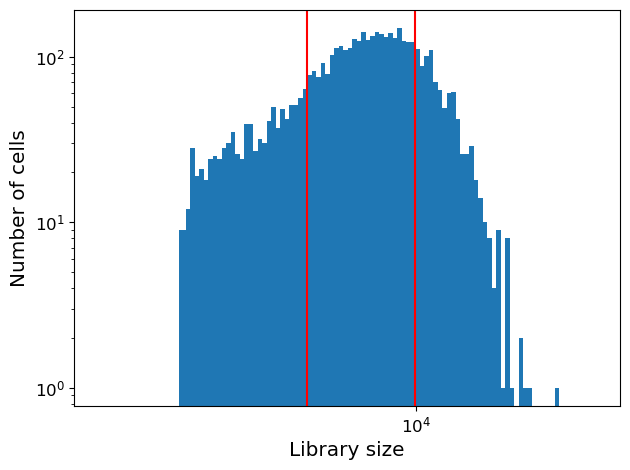

In [12]:
scprep.plot.plot_library_size(T1, percentile=[20,80])

In [13]:
filtered_batches = []
for batch in [T1, T2, T3, T4, T5]:
    batch = scprep.filter.filter_library_size(batch, percentile=20, keep_cells='above')
    batch = scprep.filter.filter_library_size(batch, percentile=80, keep_cells='below')
    filtered_batches.append(batch)
del T1, T2, T3, T4, T5 # removes objects from memory

#### 1.4. Merge all datasets and create a vector representing the time point of each sample

In this dataset, every single cell data is from a different timepoint. We will join it into a single large dataframe.

In [14]:
EBT_counts, sample_labels = scprep.utils.combine_batches(
    filtered_batches, 
    ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"],
    append_to_cell_names=True
)
del filtered_batches # removes objects from memory
EBT_counts.head()


A1BG (ENSG00000121410)  \
AAACATACCAGAGG-1_Day 00-03                     0.0   
AAACATTGAAAGCA-1_Day 00-03                     0.0   
AAACATTGAAGTGA-1_Day 00-03                     0.0   
AAACATTGGAGGTG-1_Day 00-03                     0.0   
AAACATTGGTTTCT-1_Day 00-03                     0.0   

                            A1BG-AS1 (ENSG00000268895)  \
AAACATACCAGAGG-1_Day 00-03                         0.0   
AAACATTGAAAGCA-1_Day 00-03                         0.0   
AAACATTGAAGTGA-1_Day 00-03                         0.0   
AAACATTGGAGGTG-1_Day 00-03                         0.0   
AAACATTGGTTTCT-1_Day 00-03                         0.0   

                            A1CF (ENSG00000148584)  A2M (ENSG00000175899)  \
AAACATACCAGAGG-1_Day 00-03                     0.0                    0.0   
AAACATTGAAAGCA-1_Day 00-03                     0.0                    0.0   
AAACATTGAAGTGA-1_Day 00-03                     0.0                    0.0   
AAACATTGGAGGTG-1_Day 00-03                     0.0                    0.0   
AAACATTGGTTTCT-1_Day 00-03                     0.0                    0.0   

                            A2M-AS1 (ENSG00000245105)  \
AAACATACCAGAGG-1_Day 00-03                        0.0   
AAACATTGAAAGCA-1_Day 00-03                        0.0   
AAACATTGAAGTGA-1_Day 00-03                        0.0   
AAACATTGGAGGTG-1_Day 00-03                        0.0   
AAACATTGGTTTCT-1_Day 00-03                        0.0   

                            A2ML1 (ENSG00000166535)  \
AAACATACCAGAGG-1_Day 00-03                      0.0   
AAACATTGAAAGCA-1_Day 00-03                      0.0   
AAACATTGAAGTGA-1_Day 00-03                      0.0   
AAACATTGGAGGTG-1_Day 00-03                      0.0   
AAACATTGGTTTCT-1_Day 00-03                      0.0   

                            A2ML1-AS1 (ENSG00000256661)  \
AAACATACCAGAGG-1_Day 00-03                          0.0   
AAACATTGAAAGCA-1_Day 00-03                          0.0   
AAACATTGAAGTGA-1_Day 00-03                          0.0   
AAACATTGGAGGTG-1_Day 00-03                          0.0   
AAACATTGGTTTCT-1_Day 00-03                          0.0   

                            A2ML1-AS2 (ENSG00000256904)  \
AAACATACCAGAGG-1_Day 00-03                          0.0   
AAACATTGAAAGCA-1_Day 00-03                          0.0   
AAACATTGAAGTGA-1_Day 00-03                          0.0   
AAACATTGGAGGTG-1_Day 00-03                          0.0   
AAACATTGGTTTCT-1_Day 00-03                          0.0   

                            A3GALT2 (ENSG00000184389)  \
AAACATACCAGAGG-1_Day 00-03                        0.0   
AAACATTGAAAGCA-1_Day 00-03                        0.0   
AAACATTGAAGTGA-1_Day 00-03                        0.0   
AAACATTGGAGGTG-1_Day 00-03                        0.0   
AAACATTGGTTTCT-1_Day 00-03                        0.0   

                            A4GALT (ENSG00000128274)  ...  \
AAACATACCAGAGG-1_Day 00-03                       0.0  ...   
AAACATTGAAAGCA-1_Day 00-03                       0.0  ...   
AAACATTGAAGTGA-1_Day 00-03                       0.0  ...   
AAACATTGGAGGTG-1_Day 00-03                       0.0  ...   
AAACATTGGTTTCT-1_Day 00-03                       0.0  ...   

                            ZXDC (ENSG00000070476)  ZYG11A (ENSG00000203995)  \
AAACATACCAGAGG-1_Day 00-03                     0.0                       0.0   
AAACATTGAAAGCA-1_Day 00-03                     0.0                       0.0   
AAACATTGAAGTGA-1_Day 00-03                     0.0                       0.0   
AAACATTGGAGGTG-1_Day 00-03                     0.0                       0.0   
AAACATTGGTTTCT-1_Day 00-03                     0.0                       0.0   

                            ZYG11B (ENSG00000162378)  ZYX (ENSG00000159840)  \
AAACATACCAGAGG-1_Day 00-03                       0.0                    0.0   
AAACATTGAAAGCA-1_Day 00-03                       0.0                    0.0   
AAACATTGAAGTGA-1_Day 00-03                       0.0                    0.0   


### Filtering

We filter the data by: 
1. Filtering by library size (if we did not do this prior to combining batches)
2. Removing genes that are expressed in relatively few cells.
3. Removing dead cells

We filter dead cells after library size normalization, since library size is not necessarily related to cell state.

** Filtering I: Library size filtering **

We did this before, because the library size correlated strongly with our samples. However, if we wanted to do something simplier, we could have run the following here instead:

`EBT_counts, sample_labels = scprep.filter.library_size_filter(EBT_counts, sample_labels, cutoff=2000)`

#### Filtering II: Remove rare genes

We eliminate genes that are expressed in 10 cells or fewer.

In [15]:
EBT_counts = scprep.filter.filter_rare_genes(EBT_counts, min_cells=10)

### Normalization

To correct for differences in library sizes, we divide each cell by its library size and then rescale by the median library size.

In python this is performed using the preprocessing method `library_size_normalize()`.

In [16]:
EBT_counts = scprep.normalize.library_size_normalize(EBT_counts)

#### Filtering III: Dead cell removal

Dead cells are likely to have a higher mitochondrial RNA expression level than live cells. Therefore, we remove suspected dead cells by eliminating cells that have the highest mitochondrial RNA expression levels on average.  

First let's look at the distribution of mitochontrial genes.

/Users/joaofelipe/miniconda3/envs/omics-toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='Gene expression', ylabel='Number of cells'>

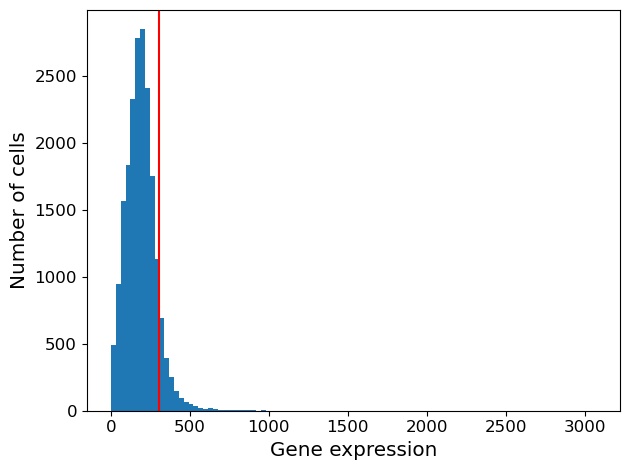

In [17]:
mito_genes = scprep.select.get_gene_set(EBT_counts, starts_with="MT-") # Get all mitochondrial genes. There are 14, FYI.
scprep.plot.plot_gene_set_expression(EBT_counts, genes=mito_genes, percentile=90)

Here we see that above the top 90th percentile, there is a steep increase in expression of mitochondrial RNAs. We'll remove these cells from further analysis.

In [18]:
EBT_counts, sample_labels = scprep.filter.filter_gene_set_expression(
    EBT_counts, sample_labels, genes=mito_genes, 
    percentile=90, keep_cells='below')

### Transformation

In scRNA-seq analysis, the data is often $\log$-transformed. This typically requires the addition of some small value to avoid taking $\log(0)$. We avoid this issue entirely by instead taking the square root transform. The square root function has a similar form as the $\log$ function with the added benefit of being stable at 0.

In [19]:
EBT_counts = scprep.transform.sqrt(EBT_counts)

In [20]:
EBT_counts

A1BG (ENSG00000121410)  \
AAACATTGAAGTGA-1_Day 00-03                0.000000   
AAACATTGGAGGTG-1_Day 00-03                0.000000   
AAACATTGGTTTCT-1_Day 00-03                0.000000   
AAACCGTGCAGAAA-1_Day 00-03                0.000000   
AAACGCACCGGTAT-1_Day 00-03                0.000000   
...                                            ...   
TTTCTACTCTGATG-1_Day 24-27                0.000000   
TTTCTACTCTTATC-1_Day 24-27                0.000000   
TTTCTACTTGAGCT-1_Day 24-27                2.071677   
TTTGCATGATGACC-1_Day 24-27                0.000000   
TTTGCATGTTCTTG-1_Day 24-27                0.000000   

                            A1BG-AS1 (ENSG00000268895)  A2M (ENSG00000175899)  \
AAACATTGAAGTGA-1_Day 00-03                         0.0                    0.0   
AAACATTGGAGGTG-1_Day 00-03                         0.0                    0.0   
AAACATTGGTTTCT-1_Day 00-03                         0.0                    0.0   
AAACCGTGCAGAAA-1_Day 00-03                         0.0                    0.0   
AAACGCACCGGTAT-1_Day 00-03                         0.0                    0.0   
...                                                ...                    ...   
TTTCTACTCTGATG-1_Day 24-27                         0.0                    0.0   
TTTCTACTCTTATC-1_Day 24-27                         0.0                    0.0   
TTTCTACTTGAGCT-1_Day 24-27                         0.0                    0.0   
TTTGCATGATGACC-1_Day 24-27                         0.0                    0.0   
TTTGCATGTTCTTG-1_Day 24-27                         0.0                    0.0   

                            A2M-AS1 (ENSG00000245105)  \
AAACATTGAAGTGA-1_Day 00-03                   0.000000   
AAACATTGGAGGTG-1_Day 00-03                   0.000000   
AAACATTGGTTTCT-1_Day 00-03                   0.000000   
AAACCGTGCAGAAA-1_Day 00-03                   0.000000   
AAACGCACCGGTAT-1_Day 00-03                   0.000000   
...                                               ...   
TTTCTACTCTGATG-1_Day 24-27                   0.000000   
TTTCTACTCTTATC-1_Day 24-27                   0.000000   
TTTCTACTTGAGCT-1_Day 24-27                   0.000000   
TTTGCATGATGACC-1_Day 24-27                   0.000000   
TTTGCATGTTCTTG-1_Day 24-27                   1.963807   

                            A2ML1 (ENSG00000166535)  A4GALT (ENSG00000128274)  \
AAACATTGAAGTGA-1_Day 00-03                      0.0                       0.0   
AAACATTGGAGGTG-1_Day 00-03                      0.0                       0.0   
AAACATTGGTTTCT-1_Day 00-03                      0.0                       0.0   
AAACCGTGCAGAAA-1_Day 00-03                      0.0                       0.0   
AAACGCACCGGTAT-1_Day 00-03                      0.0                       0.0   
...                                             ...                       ...   
TTTCTACTCTGATG-1_Day 24-27                      0.0                       0.0   
TTTCTACTCTTATC-1_Day 24-27                      0.0                       0.0   
TTTCTACTTGAGCT-1_Day 24-27                      0.0                       0.0   
TTTGCATGATGACC-1_Day 24-27                      0.0                       0.0   
TTTGCATGTTCTTG-1_Day 24-27                      0.0                       0.0   

                            AAAS (ENSG00000094914)  AACS (ENSG00000081760)  \
AAACATTGAAGTGA-1_Day 00-03                     0.0                0.000000   
AAACATTGGAGGTG-1_Day 00-03                     0.0                0.000000   
AAACATTGGTTTCT-1_Day 00-03                     0.0                0.000000   
AAACCGTGCAGAAA-1_Day 00-03                     0.0                0.000000   
AAACGCACCGGTAT-1_Day 00-03                     0.0                0.000000   
...                                            ...                     ...   
TTTCTACTCTGATG-1_Day 24-27                     0.0                0.000000   
TTTCTACTCTTATC-1_Day 24-27                     0.0                0.000000   
TTTCTACTTGAGCT-1_Day 24-27                    

# 2. Creating the AnnData objects

MIOFlow uses AnnData objects to handle the data. 
In the end, we need to create a _.h5ad_ that contains:
- gene values on _X_ (adata.X)
- phate embeddings of the data on _obsm_ (ex.: adata.obsm['X_phate])
- any extra metadata on _obs_ (ex.: adata.obs['time'], adata.obs['disease_progression'], etc...)

For this, we need to retrieve the metadata. 

In our case, the time points we saved as a DataFrame when joining all the dataset (under the sample_labels object)

For this data we don't have other labels, but they could have been added here.


In [ ]:
obs_df = pd.DataFrame({
    'time_label': sample_labels,
    # 'cell_class': cell_class,
    # 'cell_cycle_label' : cell_cycle_label
})
obs_df.head()


time_label
AAACATTGAAGTGA-1_Day 00-03  Day 00-03
AAACATTGGAGGTG-1_Day 00-03  Day 00-03
AAACATTGGTTTCT-1_Day 00-03  Day 00-03
AAACCGTGCAGAAA-1_Day 00-03  Day 00-03
AAACGCACCGGTAT-1_Day 00-03  Day 00-03

In [22]:
import scanpy as sc
adata = sc.AnnData(X=EBT_counts,obs=obs_df)

# 2. Dimensionality Reduction

### 2.1. Embedding Data Using PCA

Here we need to embed our data into a lower dimentional space.

This allows us to compute distances on PCA space and regularize by PHATE.

For this we simply compute PCA from scanpy.

In [25]:
n_components = 50
#This function will change adata inplace and add X_pca into adata.obsm
pca_df = sc.pp.pca(adata, n_comps=n_components)

In [26]:
adata

AnnData object with n_obs × n_vars = 17944 × 18019
    obs: 'time_label'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


### 2.2. Embedding Data Using PHATE

We are going to run PHATE over the lower dimensional PCA space.

### 2.2.1 Instantiating the PHATE estimator

The API of PHATE models that of Scikit Learn. First, you instantiate a PHATE estimator object with the parameters for fitting the PHATE embedding to a given dataset. Next, you use the `fit` and `fit_transform` functions to generate an embedding. For more information, check out [**the PHATE readthedocs page**](http://phate.readthedocs.io/).

We'll just use the default parameters for now, but the following parameters can be tuned (read our documentation at [phate.readthedocs.io](https://phate.readthedocs.io/) to learn more):

* `knn` : Number of nearest neighbors (default: 5). Increase this (e.g. to 20) if your PHATE embedding appears very disconnected. You should also consider increasing `knn` if your dataset is extremely large (e.g. >100k cells)
* `decay` : Alpha decay (default: 15). Decreasing `decay` increases connectivity on the graph, increasing `decay` decreases connectivity. This rarely needs to be tuned. Set it to `None` for a k-nearest neighbors kernel.
* `t` : Number of times to power the operator (default: 'auto'). This is equivalent to the amount of smoothing done to the data. It is chosen automatically by default, but you can increase it if your embedding lacks structure, or decrease it if the structure looks too compact.
* `gamma` : Informational distance constant (default: 1). `gamma=1` gives the PHATE log potential, but other informational distances can be interesting. If most of the points seem concentrated in one section of the plot, you can try `gamma=0`.

Here's the simplest way to apply PHATE:

In [27]:
phate_operator = phate.PHATE(n_jobs=-2,n_components=2)

X_phate = phate_operator.fit_transform(adata.obsm['X_pca'])

# Here we add the X_phate to adata
# X_phate is the embedding of the data and can also be used for visualization

adata.obsm['X_phate'] = X_phate


Calculating PHATE...
  Running PHATE on 17944 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 4.52 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 4.59 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.47 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.64 seconds.
  Calculated landmark operator in 2.51 seconds.
  Calculating optimal t...
    Automatically selected t = 29
  Calculated optimal t in 1.18 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.40 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.89 seconds.
Calculated PHATE in 10.57 seconds.


And then we plot using `scprep.plot.scatter2d`. For more advanced plotting, we recommend Matplotlib. If you want more help on using Matplotlib, they have [**extensive documentation**](https://matplotlib.org/tutorials/index.html) and [**many Stackoverflow threads**](https://stackoverflow.com/questions/tagged/matplotlib).

/Users/joaofelipe/miniconda3/envs/omics-toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='PHATE1', ylabel='PHATE2'>

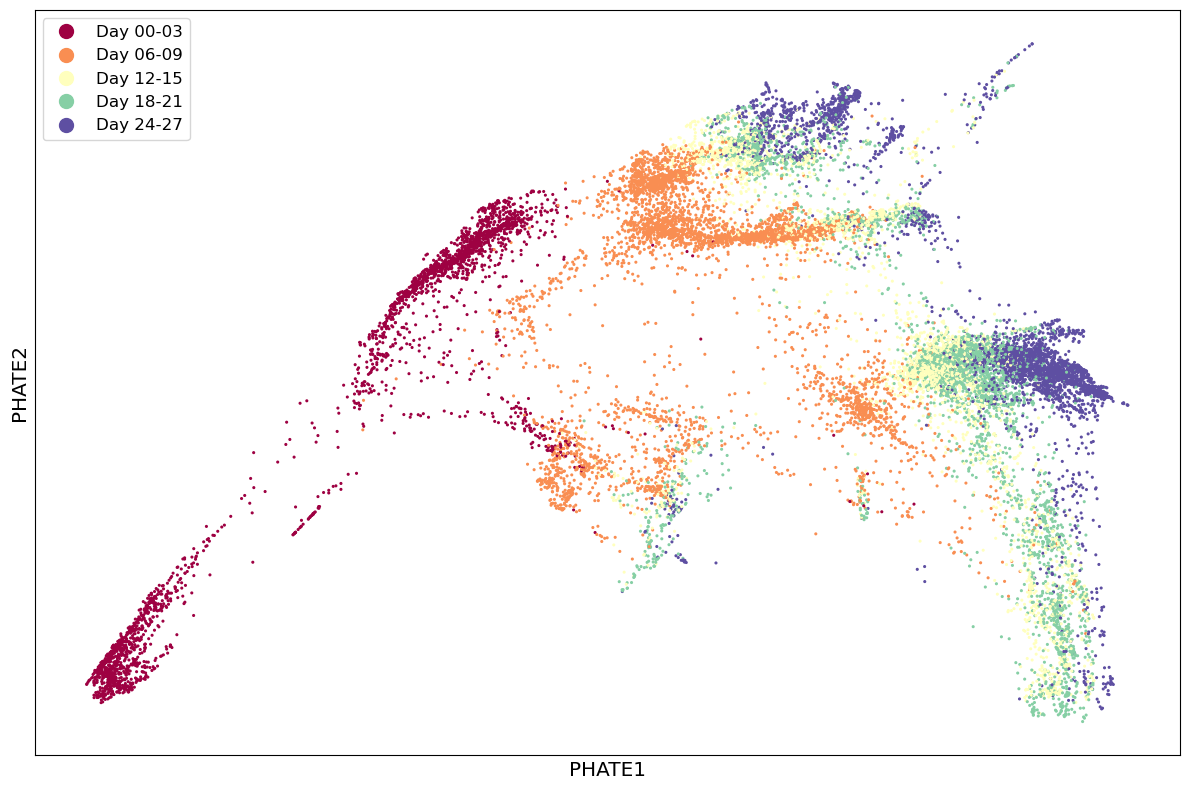

In [28]:
scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs['time_label'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

# 2. Choosing a feature to find trajectories

We want our trajectories to follow some dynamics that we want to discover trends about.
Let's start by looking at our PHATE space. This is the latent space we want to find trajectories in.

<Axes: >

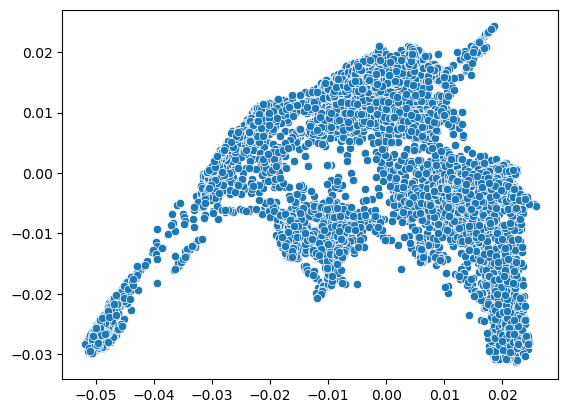

In [29]:
sns.scatterplot(x=adata.obsm['X_phate'][:,0],y=adata.obsm['X_phate'][:,1]) # Ploting the first and second phate components

Now, we need to choose a feature to "guide" our space. Let's check the avalable features:

In [30]:
adata.obs

time_label
AAACATTGAAGTGA-1_Day 00-03  Day 00-03
AAACATTGGAGGTG-1_Day 00-03  Day 00-03
AAACATTGGTTTCT-1_Day 00-03  Day 00-03
AAACCGTGCAGAAA-1_Day 00-03  Day 00-03
AAACGCACCGGTAT-1_Day 00-03  Day 00-03
...                               ...
TTTCTACTCTGATG-1_Day 24-27  Day 24-27
TTTCTACTCTTATC-1_Day 24-27  Day 24-27
TTTCTACTTGAGCT-1_Day 24-27  Day 24-27
TTTGCATGATGACC-1_Day 24-27  Day 24-27
TTTGCATGTTCTTG-1_Day 24-27  Day 24-27

[17944 rows x 1 columns]

In our case, we know we want to get trajectories over the time samples of our collected data.

We want trajectories that go from the initial sample all the way to the final time point, while following the data structure (manifold)

So we will use the 'time_label'

<Axes: >

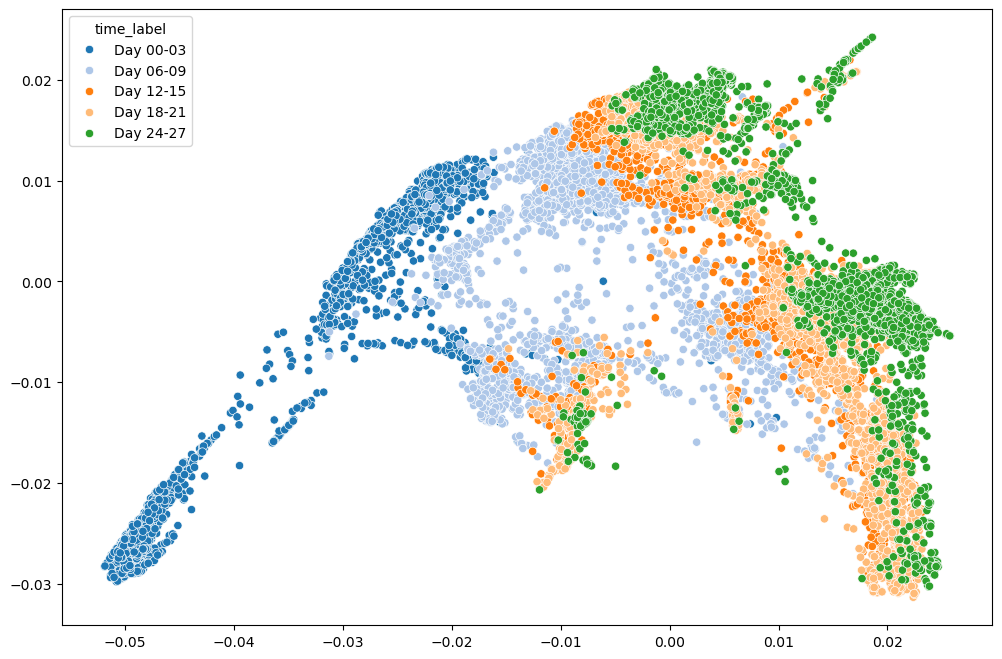

In [31]:
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(x=adata.obsm['X_phate'][:,0],y=adata.obsm['X_phate'][:,1], hue=adata.obs['time_label'],palette='tab20')

# 3. Preparing the data to MIOFlow

The MIOFlow algorithm expects data in a standart format, so we cannot simply send our adata directly to the algorithm.
THe algorithm expects a well structured dataframe, where it will work on top to discover the trajectories.

The first step is creating a new DataFrame, that contains only the embeddings dimensions (from PHATE).

The second step is creating a "samples" columns that contains the feature we want to find trajectories over. This samples column need to be discrete (onlyy integers are accepted)

This is done as follows:

In [32]:
# Create a numerical bin for each unique value (Day 00-03 0 -> 0, Day 06-09 -> 1, Day 12-15 -> 2, ...
adata.obs['discrete_time'], _ = pd.factorize(adata.obs['time_label'])

#Now lets create the DataFrame with only two columns, each with a name for the dimensions (d1,d2)
mioflow_df = pd.DataFrame(adata.obsm['X_phate'], columns=[f'd{i}' for i in range(1, adata.obsm['X_phate'].shape[1]+1)])

# Add the time labels to the dataframe as a column called 'samples' (this is expected by MIOFlow)
mioflow_df['samples'] = adata.obs['discrete_time'].values
mioflow_df

d1        d2  samples
0     -0.039642 -0.011418        0
1     -0.031467 -0.000266        0
2     -0.023445  0.007277        0
3     -0.022641  0.007924        0
4     -0.046856 -0.022250        0
...         ...       ...      ...
17939  0.013657 -0.001758        4
17940  0.016016 -0.003781        4
17941  0.022796 -0.004540        4
17942  0.023830 -0.004343        4
17943  0.019815 -0.002820        4

[17944 rows x 3 columns]

Perfect! We have the necessary input for MIOFlow. Let's do a final check that this data contains everything we want to infer on top.

<Axes: xlabel='d1', ylabel='d2'>

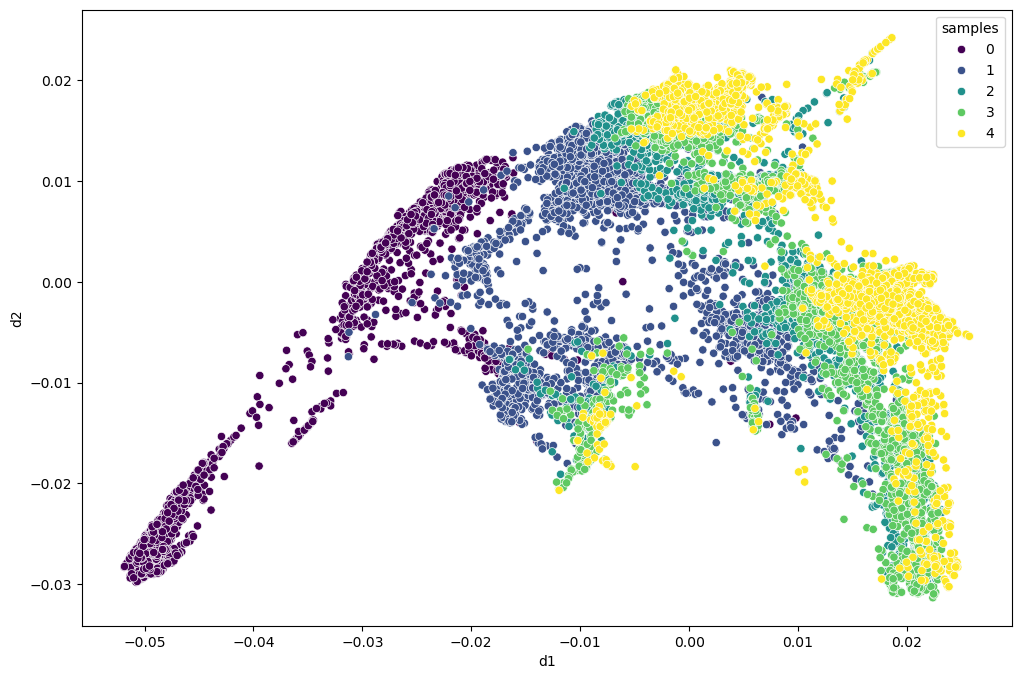

In [33]:
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(data=mioflow_df, x='d1', y='d2', hue='samples', palette='viridis')

If your data looks right, and we can see a path for the trajectories to follow, we can move on to training the MIOFlow algorithm.

# 4. The MIOFlow Model

## 4.1 Defining the hyperparameters
The MIOFlow algorithm has a lot of hyperparameters to be chosen.
Most of the default ones were picked to work just fine for most use cases.
If you are just running the algorithm by yourself, some of this parameters do not need to be defined.

However, we wanted to show all the possible changes you could make to the algorithm. The configurations are described in the next code block.

In [34]:
# =============================================================================
# MIOFlow Training Configuration
# =============================================================================

# =============================================================================
# MODEL CONFIGURATION
# =============================================================================
MODEL_CONFIG = {
    'layers': [16, 32, 16],           # Neural network architecture
    'activation': 'CELU',             # Activation function
    'scales': None,                   # SDE scales (None for default)
    'use_cuda': use_cuda,             # GPU usage
}

# =============================================================================
# TRAINING STRUCTURE CONFIGURATION
# =============================================================================
TRAINING_STRUCTURE = {
    'n_local_epochs': 40,             # Local training epochs (phase 1)
    'n_epochs': 40,                   # Global training epochs (main phase)
    'n_post_local_epochs': 0,         # Post-local training epochs (phase 3)
}

# =============================================================================
# OPTIMIZATION CONFIGURATION
# =============================================================================
OPTIMIZATION_CONFIG = {
    'criterion_type': 'ot',           # Loss criterion type ('ot' = optimal transport)
    'use_density_loss': True,         # Enable density loss (KNN-based)
    'lambda_density': 20,             # Weight for density loss
}

# =============================================================================
# DATA CONFIGURATION
# =============================================================================
DATA_CONFIG = {
    'hold_one_out': False,            # Holdout one timepoint for validation
    'sample_size': 100,               # Batch size will be the minimum between 
                                      # this and the actual minimum count for a sample
    'reverse_schema': True,           # Use reverse trajectories for training
    'reverse_n': 2,                   # Number of reverse trajectories
}

# =============================================================================
# ADVANCED FEATURES (typically not used for single-cell data)
# =============================================================================
ADVANCED_CONFIG = {
    'autoencoder': None,              # GeodesicAutoencoder (None = disabled)
    'use_emb': False,                 # Use embeddings
    'use_gae': False,                 # Use Geodesic AutoEncoder
}

# =============================================================================
# VISUALIZATION AND OUTPUT
# =============================================================================
OUTPUT_CONFIG = {
    'exp_dir': '.',                   # Experiment directory
    'plot_every': None,               # Plot frequency during training
    'n_points': 100,                  # Number of points for visualization
    'n_trajectories': 100,            # Number of trajectories for visualization
    'n_bins': 100,                    # Number of bins for discretization
}

### 4.2 Creating the MIOFlow operator
Now, we just need to pass all our data, the mioflow_df and the configurations into our MIOFlow algorithm.

You'll see that we need to pass both our adata and the mioflow_df. 
This is necessary for the algorithm to retrieve gene trends in the end.

In [35]:
# =============================================================================
# INITIALIZE MIOFLOW WITH CONFIG DICTIONARIES
# =============================================================================

mioflow_operator = MIOFlow(
    adata,
    input_df=mioflow_df,
    obsm_key="X_phate",
    debug_level='info',

    model_config=MODEL_CONFIG,  # Pass the model configs as a single parameter

    # Unpack all configurations
    **TRAINING_STRUCTURE,
    **OPTIMIZATION_CONFIG,
    **DATA_CONFIG,
    **ADVANCED_CONFIG,
    **OUTPUT_CONFIG,
)

2025-09-08 11:06:56,222 - MIOFlow - INFO - MIOFlow initialized with 17944 cells and 18019 genes
2025-09-08 11:06:56,223 - MIOFlow - INFO - Output directory: .


## 4.3 Training the algorithm

In [36]:
## THIS STEP SHOULD TAKE AROUND 5 MINUTES !
# Fit the model with the configurations
mioflow = mioflow_operator.fit()

2025-09-08 11:06:56,232 - MIOFlow - INFO - Starting MIOFlow fitting
2025-09-08 11:06:56,240 - MIOFlow - INFO - Training with structure: {'n_local_epochs': 40, 'n_epochs': 40, 'n_post_local_epochs': 0}
2025-09-08 11:06:56,241 - MIOFlow - INFO - Using CUDA: False
Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | net     | Sequential | 2.9 K  | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training PHATE Autoencoder with 17944 cells and 2 dimensions


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


Training MIOFlow trajectory inference model


Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

/Users/joaofelipe/Yale/Omics Toolbox/4_Code/MIOFlow/MIOFlow/train.py:265: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  batch_loss = torch.Tensor(batch_loss).float()


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

2025-09-08 11:08:42,488 - MIOFlow - INFO - MIOFlow fitting completed successfully


## 4.4 Observing the training loss

The loss functions need to go down during training, this means that our algorithm is learning on each new data point it's passing by

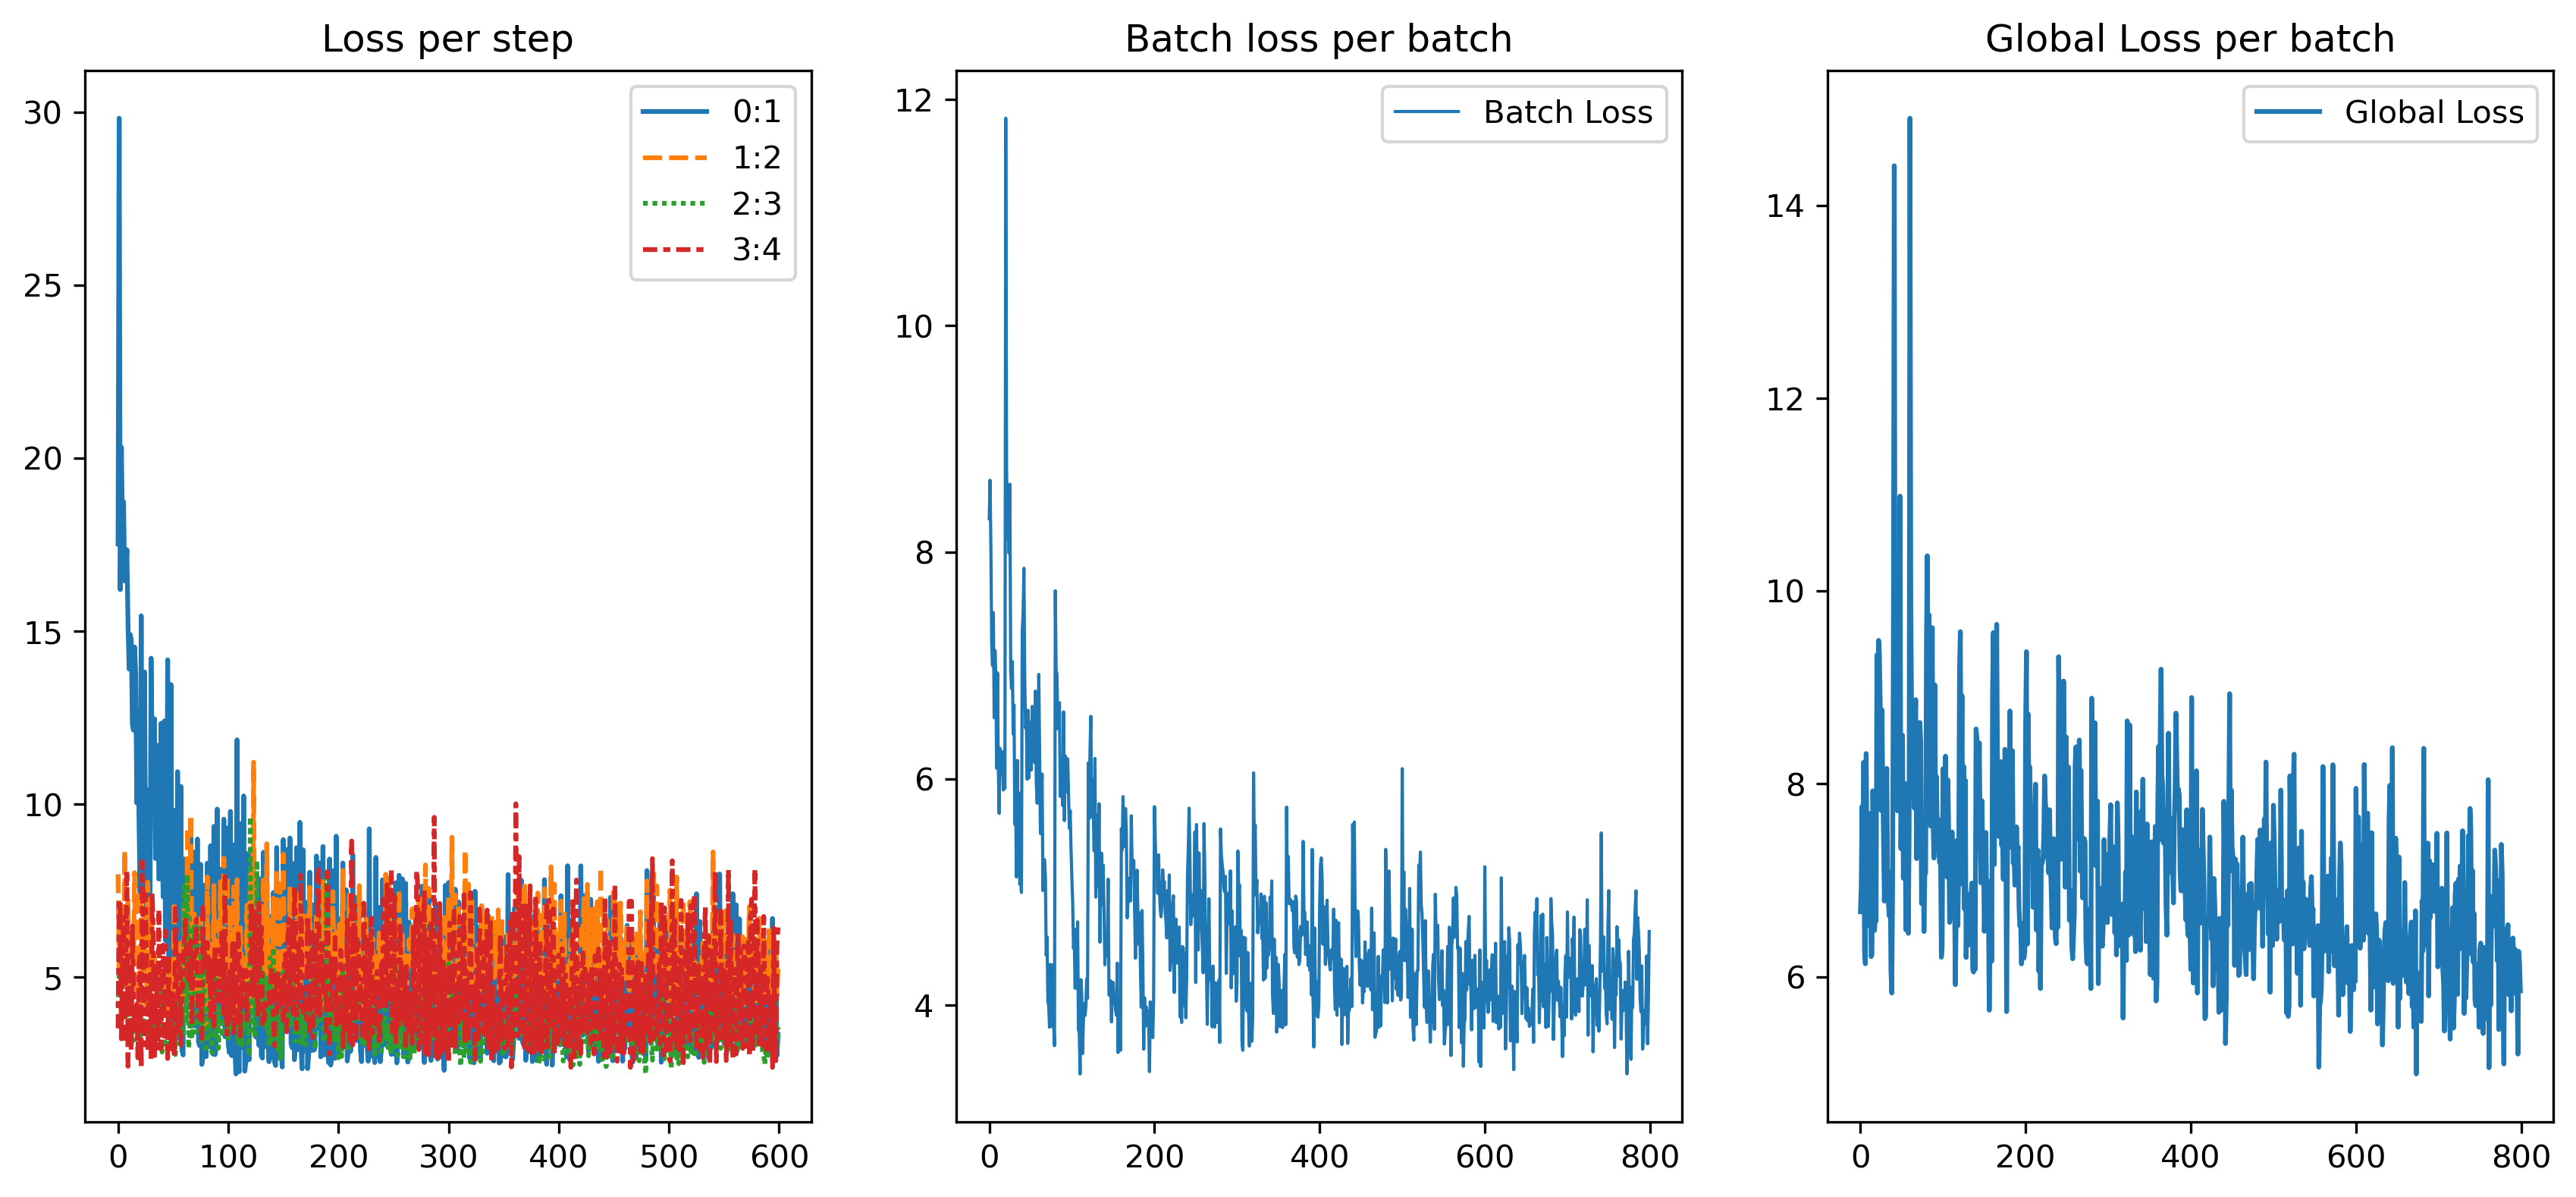

In [37]:
plot_losses(
    mioflow.local_losses, 
    mioflow.batch_losses, 
    mioflow.globe_losses, 
)

## 4.5 Visualizing the MIOFlow Outputs

The MIOFlow object contains every information needed after traning.
Our trajectories where saved under:
```mioflow.trajectories```

In [38]:
mioflow.trajectories.shape # The trajectories have the shape (n_trajectories, n_points, n_dimensions)

(100, 100, 2)

In [39]:
trajectoriespts = mioflow.trajectories * mioflow.std_vals + mioflow.mean_vals
true_data = mioflow.df[[f'd{i}' for i in range(1, len(mioflow.df.columns))]] * mioflow.std_vals + mioflow.mean_vals

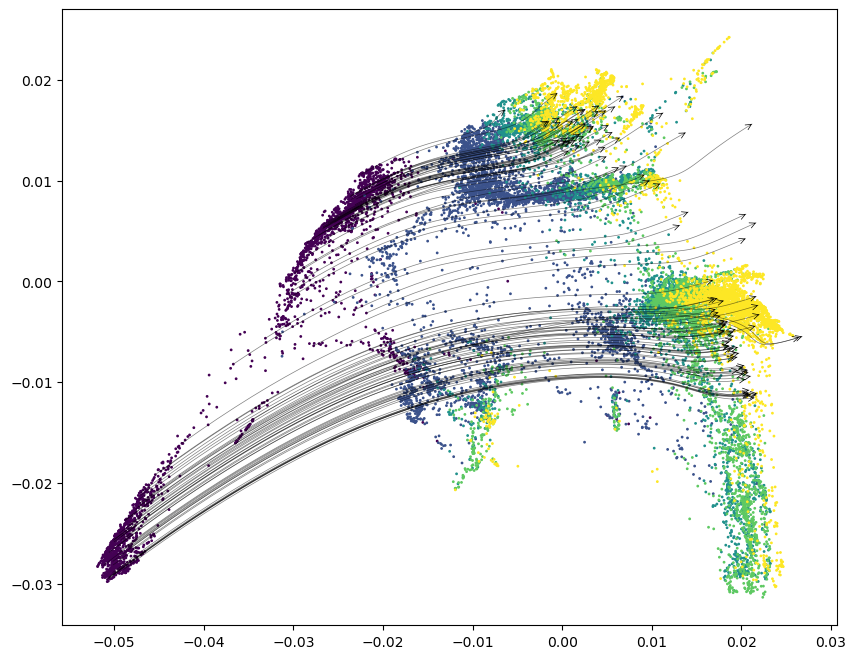

In [40]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(true_data.values[:, 0], true_data.values[:, 1], c=mioflow.df['samples'].values, cmap='viridis', s=1)
for i,traj in enumerate(np.transpose(trajectoriespts, axes=(1,0,2))):
    # widths = m_traj[:,i]
    plt.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black')
    plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle='->', color='Black', lw=.5, mutation_scale=10))

# 5. Decoding back to gene space

The interest of finding these trajectories in PHATE space is that now we can decode our trajectories back to gene space.

This way we can understand how they behave in terms of the real gene trends.

The function: ```mioflow.decode_to_gene_space()``` will take our trajectories and return them in the gene space based to mioflow with our adata.

In [41]:
trajectories_gene_space = mioflow.decode_to_gene_space()

In [42]:
trajectories_gene_space.shape # this has the shape (n_trajectories,n_points,n_genes)

(100, 100, 18019)

Now, let's choose some genes to visualize how they change in our trajectory. 
Scanpy has a function where we can retrieve the top_n genes that varies a lot in our data. 
Let's focus on those first. You can then just play with genes you are interested in.

In [43]:
sc.pp.highly_variable_genes(adata, n_top_genes=25) # this create a boolean mask saying if a gene is in the top 25 highly variable genes or not.

example_genes = adata.var_names[adata.var['highly_variable']] # Let's select only the columns that are highly variable
print(example_genes)
example_gene_mask = adata.var_names.isin(example_genes)

Index(['AC007325.4 (ENSG00000278817)', 'AFP (ENSG00000081051)',
       'APOM (ENSG00000204444)', 'CA2 (ENSG00000104267)',
       'CXCL1 (ENSG00000163739)', 'CXCL10 (ENSG00000169245)',
       'CXCL3 (ENSG00000163734)', 'CYP26A1 (ENSG00000095596)',
       'DSG3 (ENSG00000134757)', 'ESM1 (ENSG00000164283)',
       'GNRH2 (ENSG00000125787)', 'HBE1 (ENSG00000213931)',
       'ISG15 (ENSG00000187608)', 'LGALS3 (ENSG00000131981)',
       'LINC01356 (ENSG00000215866)', 'MT1E (ENSG00000169715)',
       'RBP4 (ENSG00000138207)', 'REN (ENSG00000143839)',
       'RGCC (ENSG00000102760)', 'SERPINA1 (ENSG00000197249)',
       'SERPINB2 (ENSG00000197632)', 'SOST (ENSG00000167941)',
       'SRGN (ENSG00000122862)', 'TPPP3 (ENSG00000159713)',
       'TYRP1 (ENSG00000107165)'],
      dtype='object')


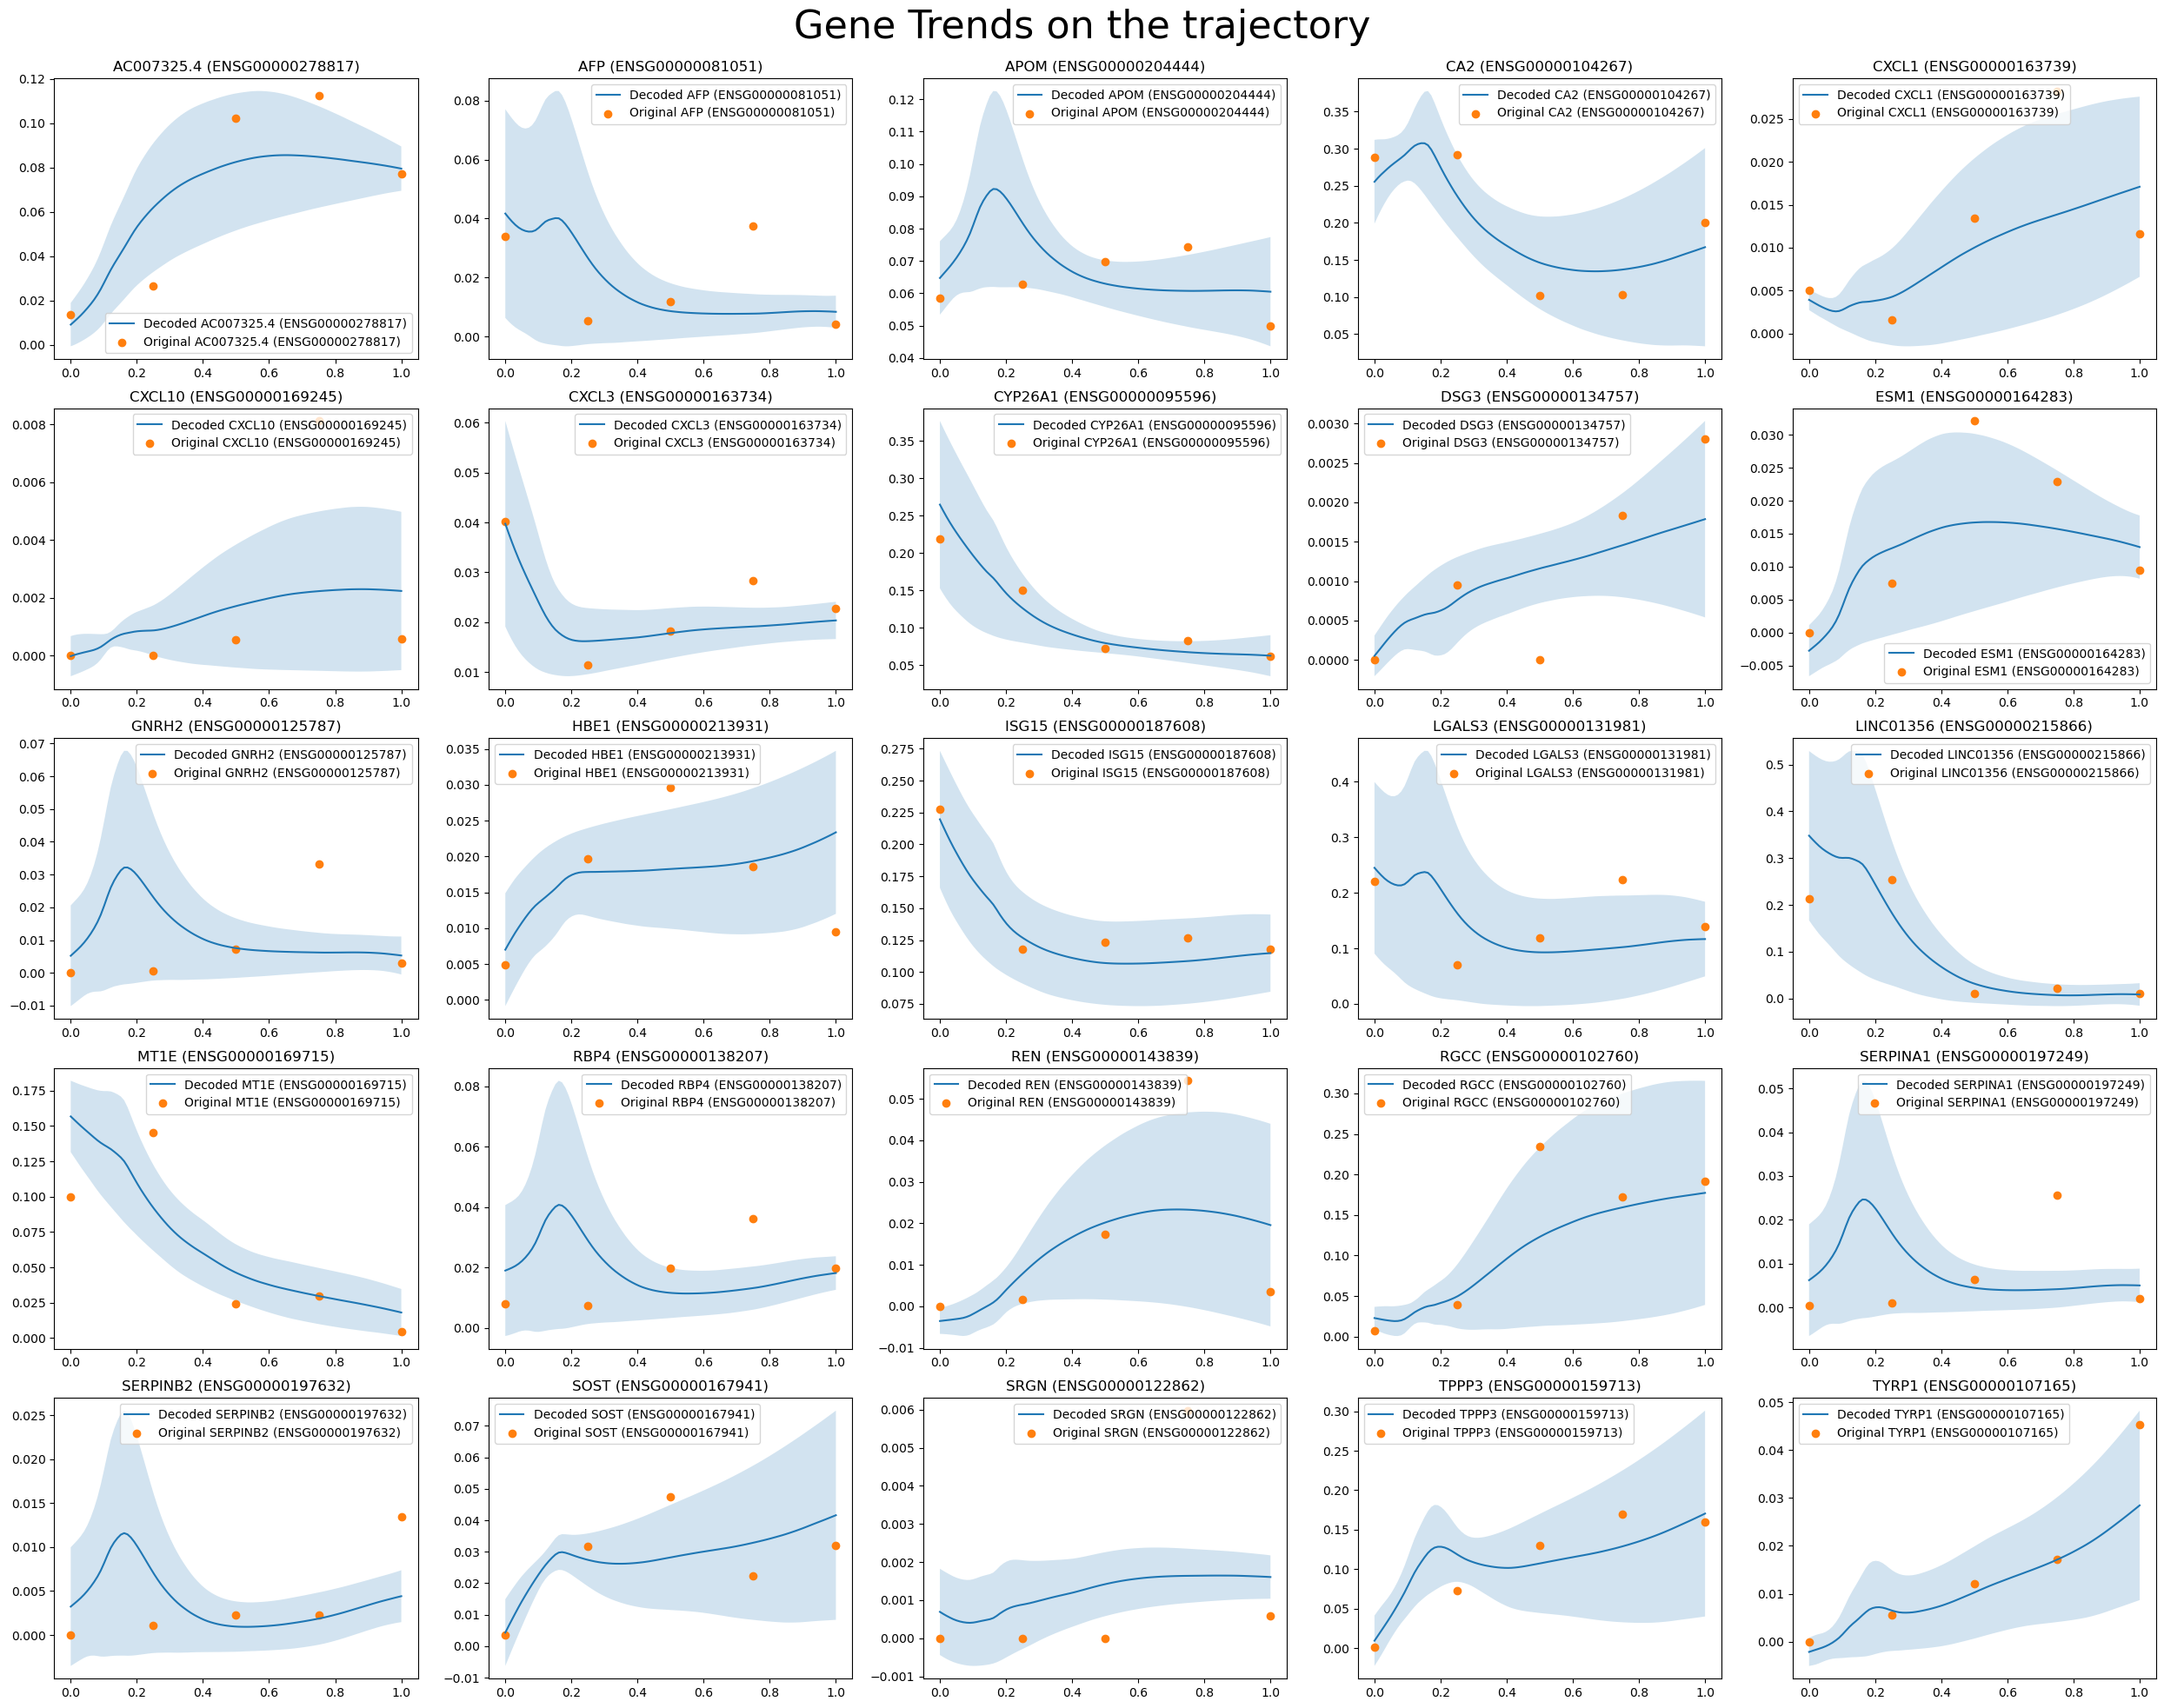

In [44]:
# Retrieving interest genes
adata_example_gene = adata[:, example_gene_mask]
decoded_example_gene = trajectories_gene_space[:, :, example_gene_mask]
decoded_example_gene_mean = decoded_example_gene.mean(axis=1)
decoded_example_gene_std = decoded_example_gene.std(axis=1)

# Setting the y axis to be through the entire trajectory
x_time = np.linspace(0, 1, traj.shape[0])
x_time_data = adata_example_gene.obs['discrete_time']
x_time_data = (x_time_data - x_time_data.min()) / (x_time_data.max() - x_time_data.min())

# Filtering the data to only show the genes of interest
data_df = pd.DataFrame(adata_example_gene.X.toarray(), columns=example_genes, index=adata_example_gene.obs_names)
data_df['x_time'] = x_time_data
data_mean = data_df.groupby('x_time').mean()
data_std = data_df.groupby('x_time').std()

# Plotting all genes in a grid
# For this we need to know how many genes we have
n_genes = decoded_example_gene_mean.shape[1]
n_rows = int(np.ceil(np.sqrt(n_genes)))
n_cols = int(np.ceil(n_genes / n_rows))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

# Finally, we plot each gene in a subplot
## The plots have the mean of the decoded gene over all trajectories in blue and the shade is the variance
for i in range(n_genes):
    ax = axes[i]
    ax.plot(x_time, decoded_example_gene_mean[:,i], label=f'Decoded {example_genes[i].split("_Cycle")[-1]}')
    ax.fill_between(x_time, decoded_example_gene_mean[:,i] - decoded_example_gene_std[:,i], decoded_example_gene_mean[:,i] + decoded_example_gene_std[:,i], alpha=0.2)
    ax.scatter(data_mean.index, data_mean[example_genes[i]], label=f'Original {example_genes[i].split("_Cycle")[-1]}')
    ax.legend()
    ax.set_title(example_genes[i])
    
# Hide empty subplots
for i in range(n_genes, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.94)  # Leave space at top
plt.suptitle('Gene Trends on the trajectory', fontsize=32)  # Position suptitle in the space

plt.show()

## Visualizing a single interest gene

If you have a specific gene you want to investigate, the steps should be as easy as the ones above. The only difference is that you need to select a single interest_gene to use as mask. Here is some code so you can investigate a specific marker of interest.

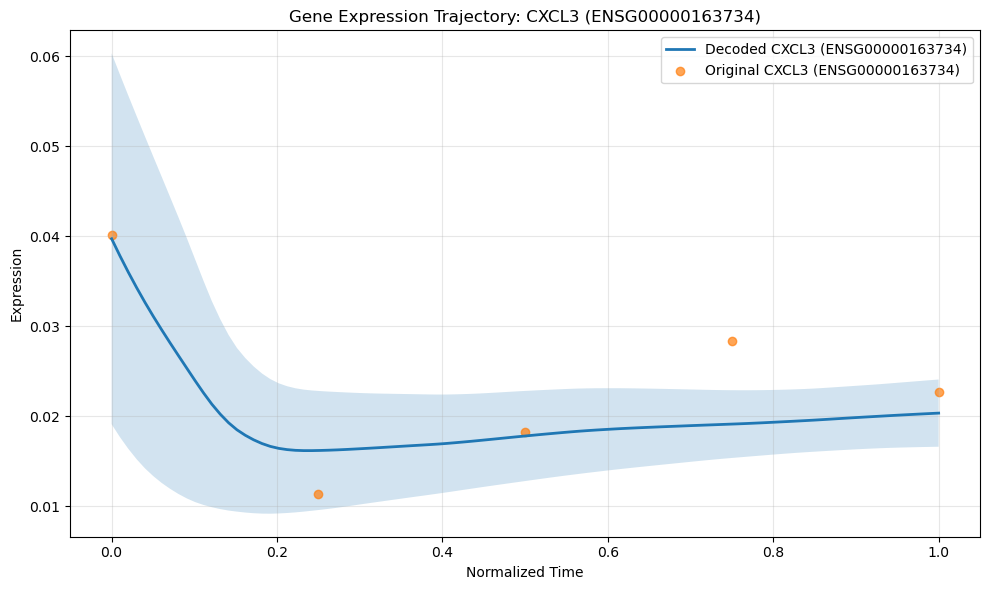

In [46]:
# Pick gene of interest
interest_gene = 'CXCL3 (ENSG00000163734)'

# Get gene data
gene_mask = adata.var_names.isin([interest_gene])
gene_data = adata[:, gene_mask]

# Decoded trajectory data
decoded_data = trajectories_gene_space[:, :, gene_mask]
decoded_mean = decoded_data.mean(axis=1).flatten()
decoded_std = decoded_data.std(axis=1).flatten()

# Time normalization
x_time = np.linspace(0, 1, len(decoded_mean))
obs_time = gene_data.obs['discrete_time']
obs_time_norm = (obs_time - obs_time.min()) / (obs_time.max() - obs_time.min())

# Original data aggregation
orig_df = pd.DataFrame({
    'expression': gene_data.X.toarray().flatten(),
    'time': obs_time_norm
})
orig_mean = orig_df.groupby('time')['expression'].mean()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_time, decoded_mean, label=f'Decoded {interest_gene}', linewidth=2)
ax.fill_between(x_time, decoded_mean - decoded_std, decoded_mean + decoded_std, alpha=0.2)
ax.scatter(orig_mean.index, orig_mean.values, label=f'Original {interest_gene}', alpha=0.7)

ax.set_xlabel('Normalized Time')
ax.set_ylabel('Expression')
ax.set_title(f'Gene Expression Trajectory: {interest_gene}')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Focusing on a specific trajectory

The above cells are looking into the average between all the trajectories in our data.
In our case, we know that some trajectories are more related to apoptosis and other to different proceses.

For this, let's look into specific trajectories.

## 6.1 Trajectory closer to the left

Target: (-0.006, 0.02)
Selected trajectory 73 at (-0.01, 0.02)


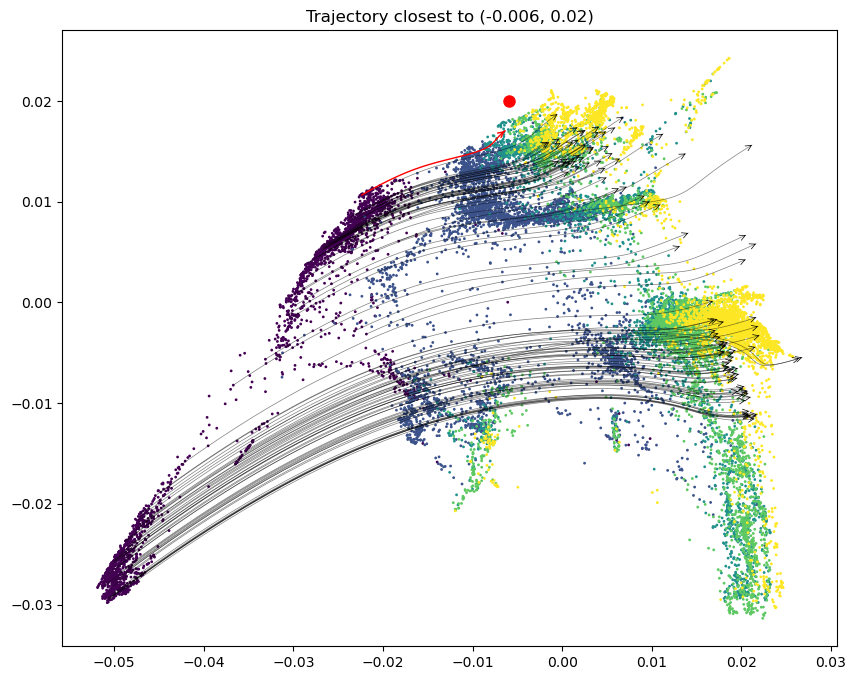

In [47]:
# Choose trajectory based on arrow's x and y coordinates
target_x = -0.006  # Target x-coordinate
target_y = 0.02 # Target y-coordinate

fig = plt.figure(figsize=(10, 8))
plt.scatter(true_data.values[:, 0], true_data.values[:, 1], 
           c=mioflow.df['samples'].values, cmap='viridis', s=1)

# Find trajectory with arrow closest to target point (target_x, target_y)
arrow_positions = []
distances = []
for i, traj in enumerate(np.transpose(trajectoriespts, axes=(1,0,2))):
    arrow_x = traj[-1, 0]  # x-coordinate of arrow (end point)
    arrow_y = traj[-1, 1]  # y-coordinate of arrow (end point)
    arrow_positions.append((arrow_x, arrow_y))
    
    # Calculate Euclidean distance to target point
    distance = np.sqrt((arrow_x - target_x)**2 + (arrow_y - target_y)**2)
    distances.append(distance)

# Find closest trajectory
highlight_trajectory = distances.index(min(distances))

print(f"Target: ({target_x}, {target_y})")
print(f"Selected trajectory {highlight_trajectory} at ({arrow_positions[highlight_trajectory][0]:.2f}, {arrow_positions[highlight_trajectory][1]:.2f})")

for i, traj in enumerate(np.transpose(trajectoriespts, axes=(1,0,2))):
    if i == highlight_trajectory:
        color = 'red'
        linewidth = 1.0
        alpha = 1.0
    else:
        color = 'black'
        linewidth = 0.5
        alpha = 0.5
    
    plt.plot(traj[:, 0], traj[:, 1], alpha=alpha, linewidth=linewidth, color=color)
    plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle='->', color=color, lw=linewidth, mutation_scale=10))

# Mark target point
plt.plot(target_x, target_y, 'ro', markersize=8)
plt.title(f'Trajectory closest to ({target_x}, {target_y})')
plt.show()

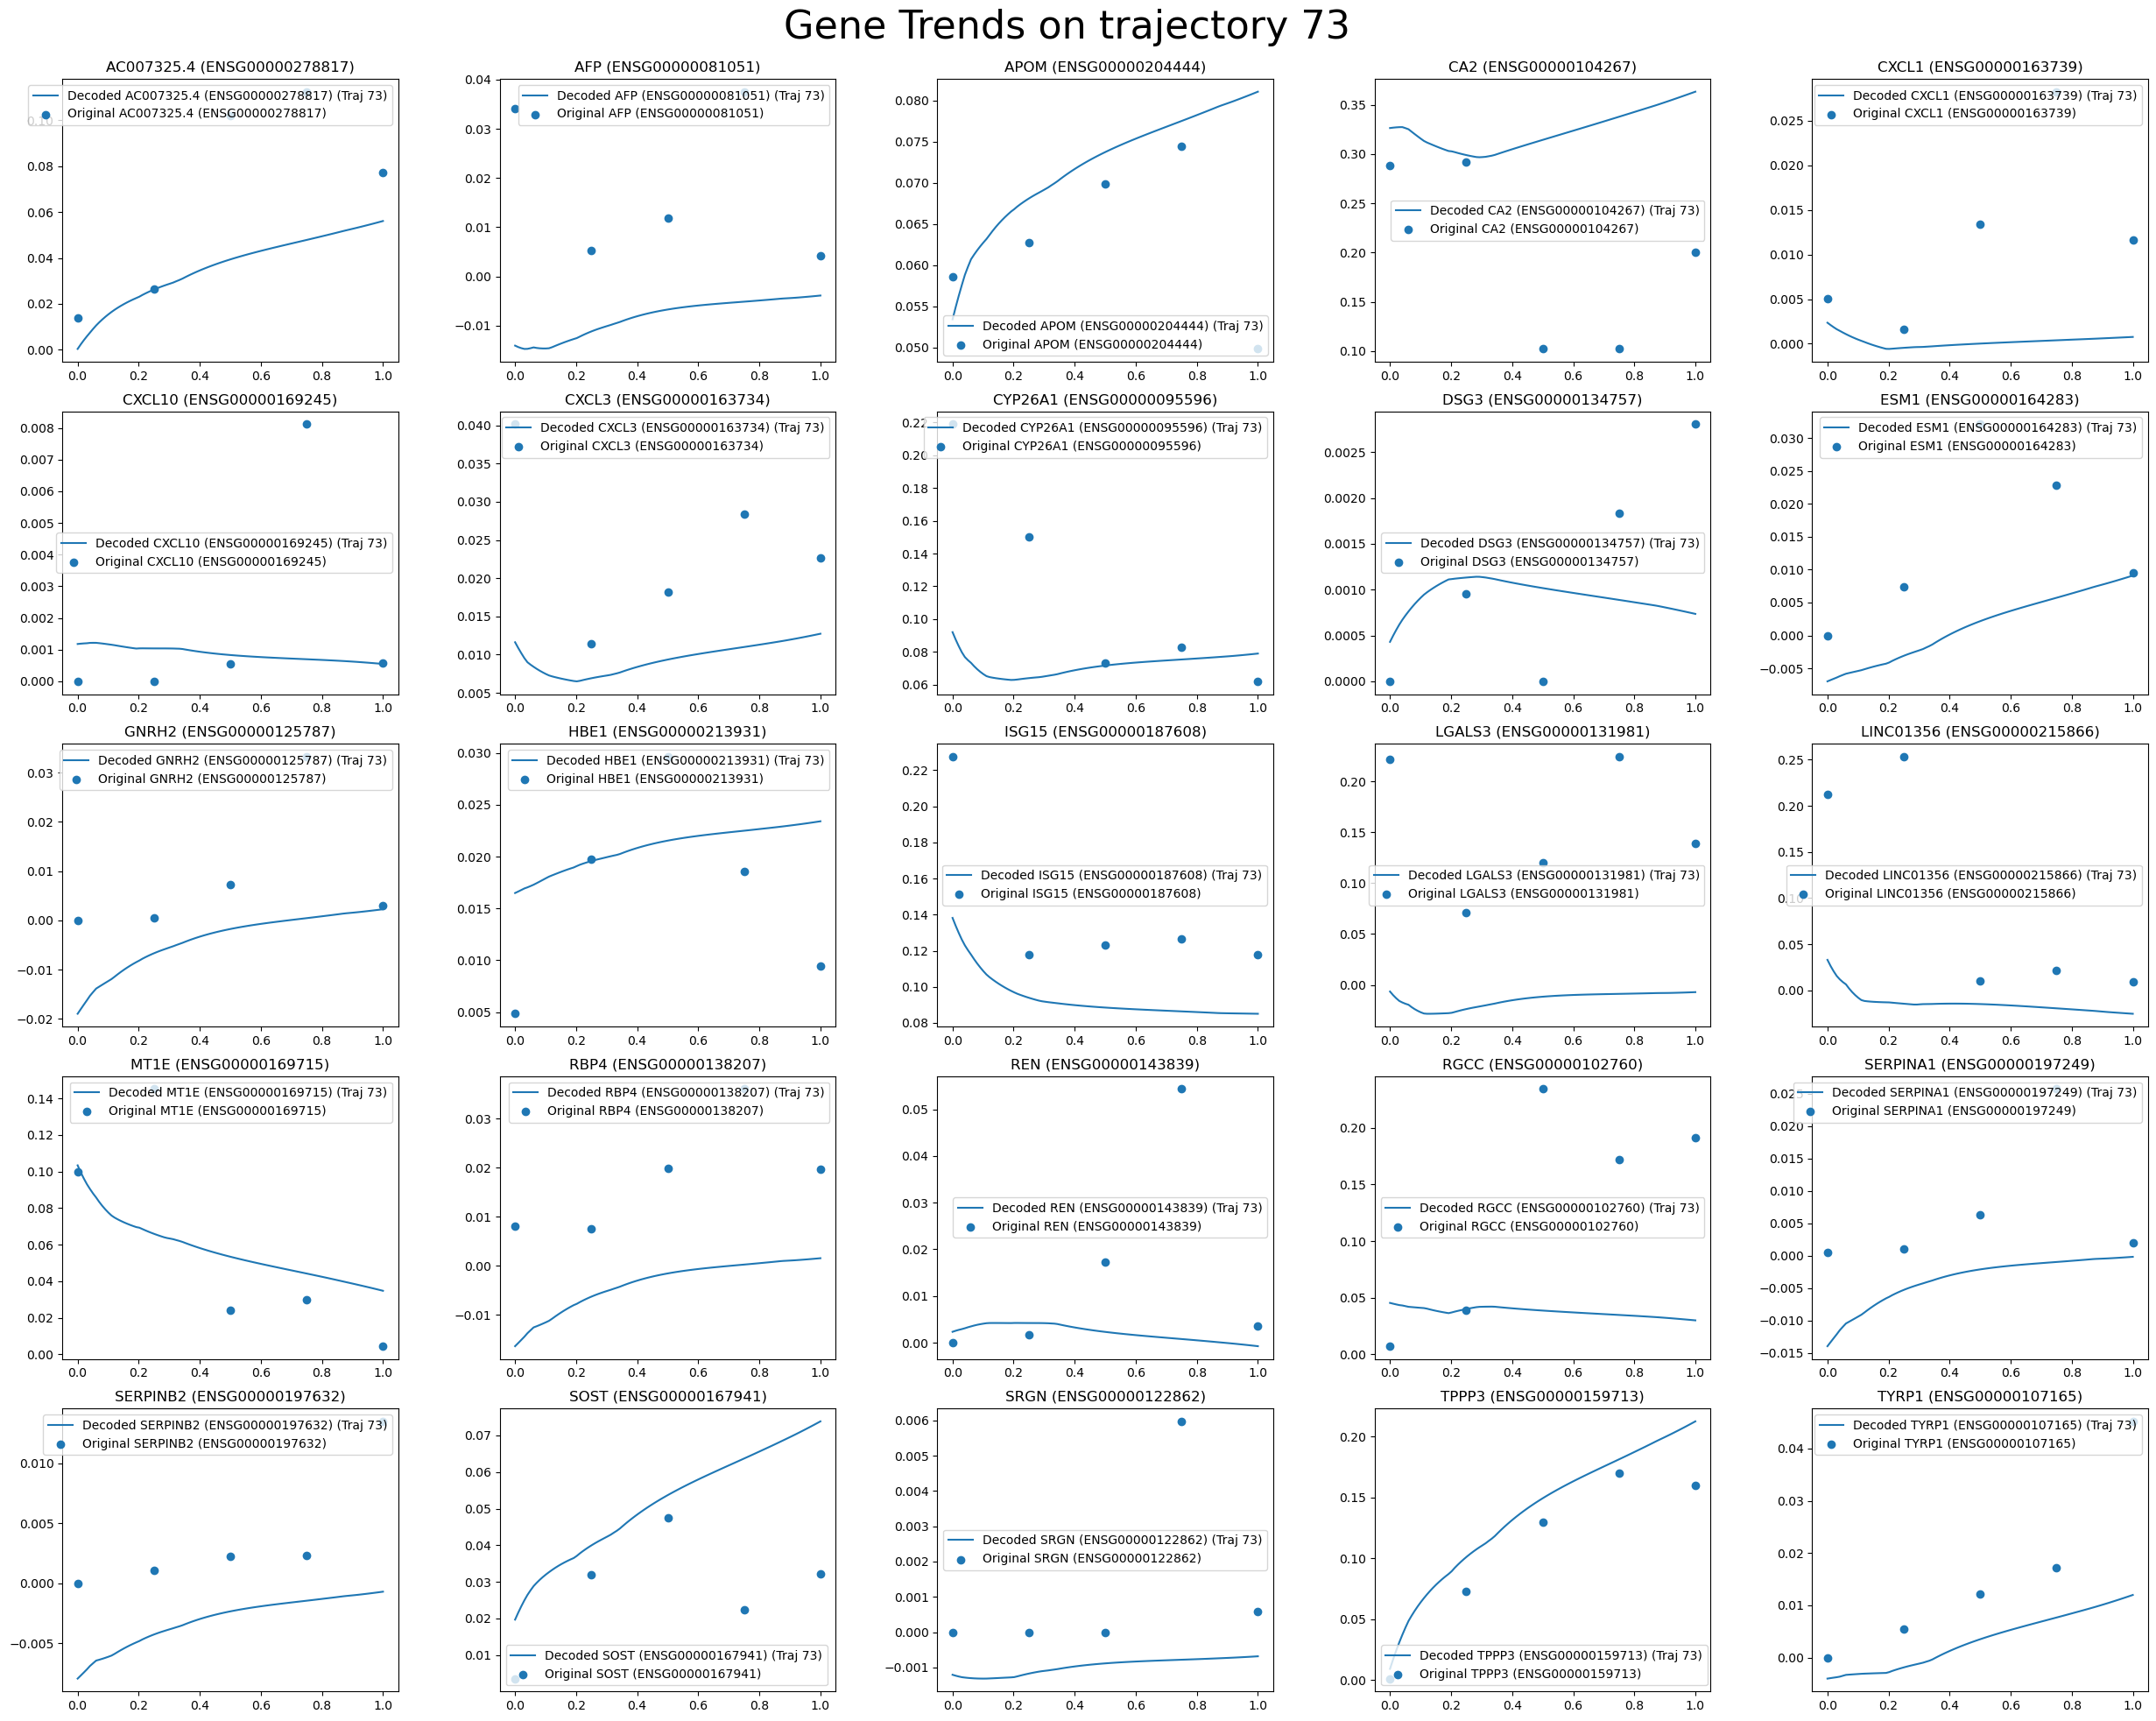

In [48]:
# Define which trajectory to highlight (you can set this to any trajectory index)

# Retrieving interest genes
adata_example_gene = adata[:, example_gene_mask]
decoded_example_gene = trajectories_gene_space[:, :, example_gene_mask]

# Extract the specific highlighted trajectory instead of computing mean/std across all trajectories
decoded_highlight_trajectory = decoded_example_gene[:, highlight_trajectory, :]

# Setting the y axis to be through the entire trajectory
x_time = np.linspace(0, 1, traj.shape[0])
x_time_data = adata_example_gene.obs['discrete_time']
x_time_data = (x_time_data - x_time_data.min()) / (x_time_data.max() - x_time_data.min())

# Filtering the data to only show the genes of interest
data_df = pd.DataFrame(adata_example_gene.X.toarray(), columns=example_genes, index=adata_example_gene.obs_names)
data_df['x_time'] = x_time_data
data_mean = data_df.groupby('x_time').mean()
data_std = data_df.groupby('x_time').std()

# Plotting all genes in a grid
# For this we need to know how many genes we have
n_genes = decoded_highlight_trajectory.shape[1]
n_rows = int(np.ceil(np.sqrt(n_genes)))
n_cols = int(np.ceil(n_genes / n_rows))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

# Finally, we plot each gene in a subplot
## The plots have the highlighted trajectory in blue (no variance shading since it's a single trajectory)
for i in range(n_genes):
    ax = axes[i]
    ax.plot(x_time, decoded_highlight_trajectory[:,i], label=f'Decoded {example_genes[i].split("_Cycle")[-1]} (Traj {highlight_trajectory})')
    ax.scatter(data_mean.index, data_mean[example_genes[i]], label=f'Original {example_genes[i].split("_Cycle")[-1]}')
    ax.legend()
    ax.set_title(example_genes[i])
    
# Hide empty subplots
for i in range(n_genes, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.94)  # Leave space at top
plt.suptitle(f'Gene Trends on trajectory {highlight_trajectory}', fontsize=32)  # Position suptitle in the space

plt.show()

## 6.2 Trajectory closer to the right endpoints

Target: (0.01, 0.018)
Selected trajectory 78 at (0.01, 0.02)


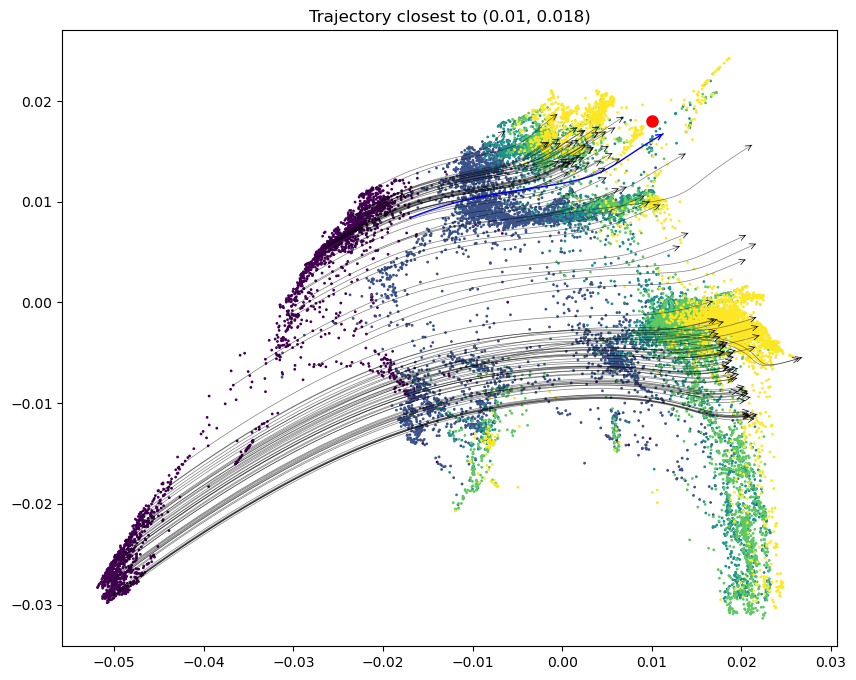

In [49]:
# Choose trajectory based on arrow's x and y coordinates
target_x = 0.01  # Target x-coordinate
target_y = 0.018 # Target y-coordinate

fig = plt.figure(figsize=(10, 8))
plt.scatter(true_data.values[:, 0], true_data.values[:, 1], 
           c=mioflow.df['samples'].values, cmap='viridis', s=1)

# Find trajectory with arrow closest to target point (target_x, target_y)
arrow_positions = []
distances = []
for i, traj in enumerate(np.transpose(trajectoriespts, axes=(1,0,2))):
    arrow_x = traj[-1, 0]  # x-coordinate of arrow (end point)
    arrow_y = traj[-1, 1]  # y-coordinate of arrow (end point)
    arrow_positions.append((arrow_x, arrow_y))
    
    # Calculate Euclidean distance to target point
    distance = np.sqrt((arrow_x - target_x)**2 + (arrow_y - target_y)**2)
    distances.append(distance)

# Find closest trajectory
highlight_trajectory = distances.index(min(distances))

print(f"Target: ({target_x}, {target_y})")
print(f"Selected trajectory {highlight_trajectory} at ({arrow_positions[highlight_trajectory][0]:.2f}, {arrow_positions[highlight_trajectory][1]:.2f})")

for i, traj in enumerate(np.transpose(trajectoriespts, axes=(1,0,2))):
    if i == highlight_trajectory:
        color = 'blue'
        linewidth = 1.0
        alpha = 1.0
    else:
        color = 'black'
        linewidth = 0.5
        alpha = 0.5
    
    plt.plot(traj[:, 0], traj[:, 1], alpha=alpha, linewidth=linewidth, color=color)
    plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle='->', color=color, lw=linewidth, mutation_scale=10))

# Mark target point
plt.plot(target_x, target_y, 'ro', markersize=8)
plt.title(f'Trajectory closest to ({target_x}, {target_y})')
plt.show()

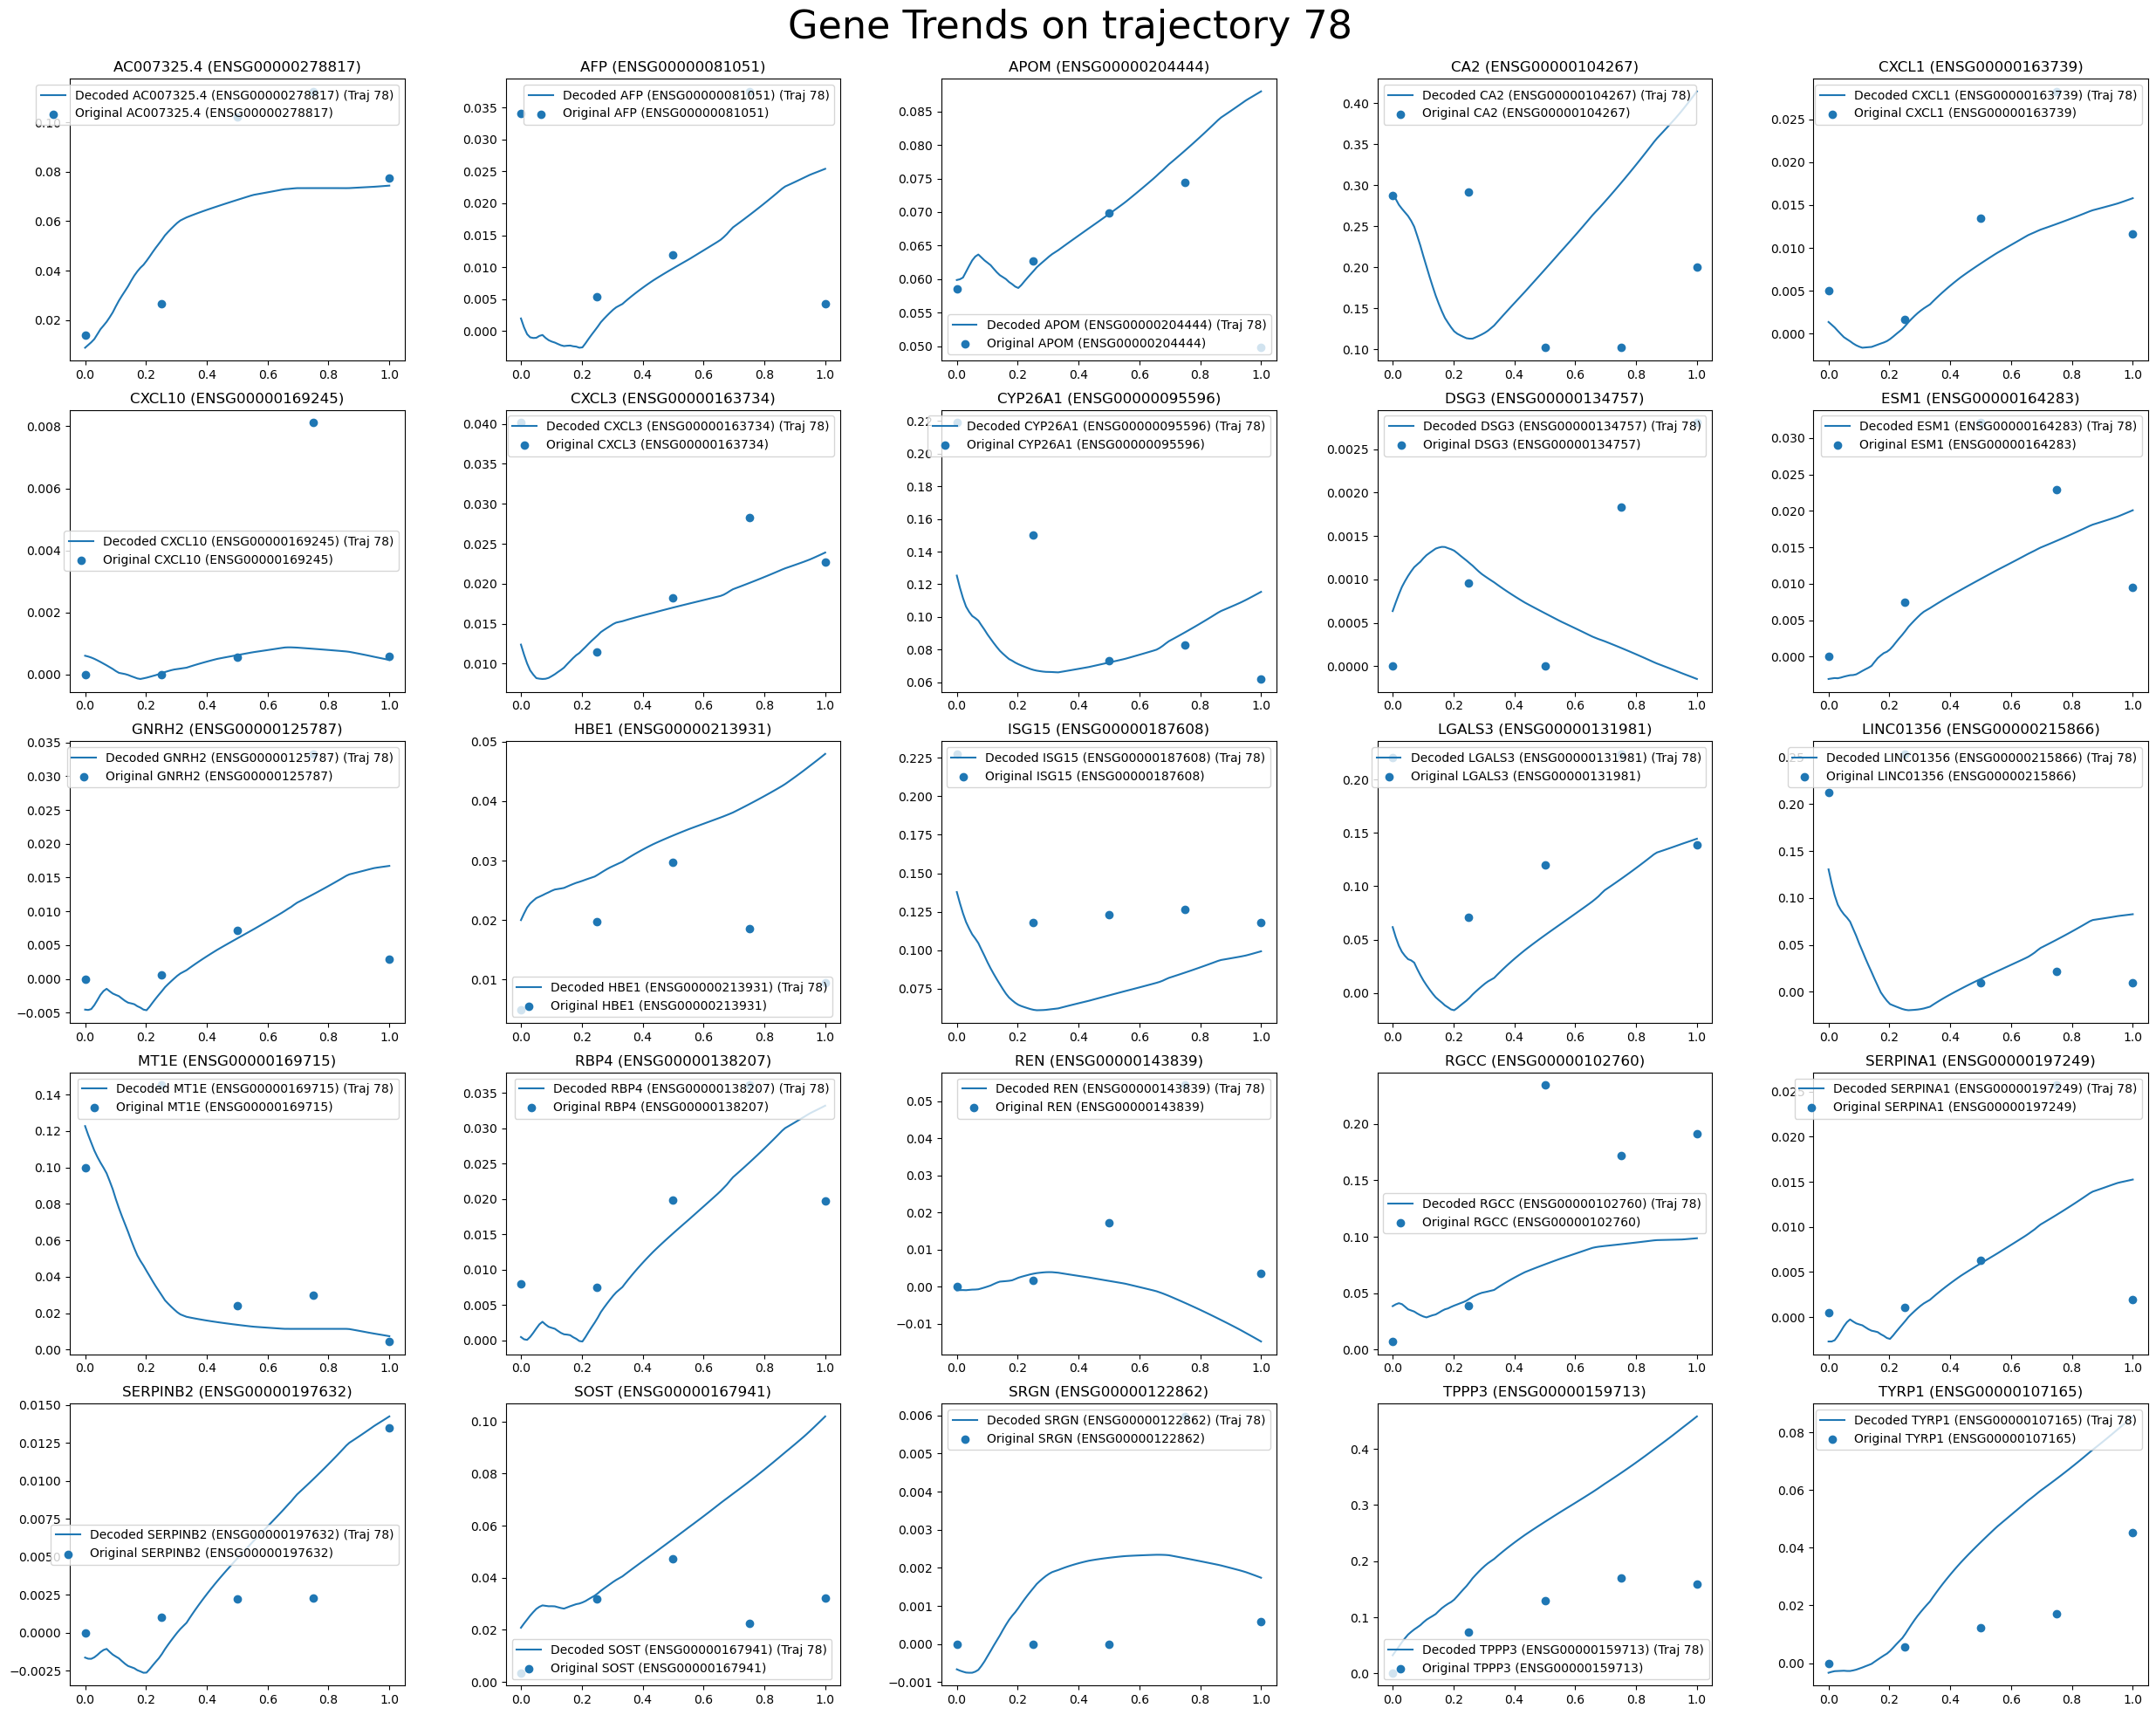

In [50]:
# Define which trajectory to highlight (you can set this to any trajectory index)

# Retrieving interest genes
adata_example_gene = adata[:, example_gene_mask]
decoded_example_gene = trajectories_gene_space[:, :, example_gene_mask]

# Extract the specific highlighted trajectory instead of computing mean/std across all trajectories
decoded_highlight_trajectory = decoded_example_gene[:, highlight_trajectory, :]

# Setting the y axis to be through the entire trajectory
x_time = np.linspace(0, 1, traj.shape[0])
x_time_data = adata_example_gene.obs['discrete_time']
x_time_data = (x_time_data - x_time_data.min()) / (x_time_data.max() - x_time_data.min())

# Filtering the data to only show the genes of interest
data_df = pd.DataFrame(adata_example_gene.X.toarray(), columns=example_genes, index=adata_example_gene.obs_names)
data_df['x_time'] = x_time_data
data_mean = data_df.groupby('x_time').mean()
data_std = data_df.groupby('x_time').std()

# Plotting all genes in a grid
# For this we need to know how many genes we have
n_genes = decoded_highlight_trajectory.shape[1]
n_rows = int(np.ceil(np.sqrt(n_genes)))
n_cols = int(np.ceil(n_genes / n_rows))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

# Finally, we plot each gene in a subplot
## The plots have the highlighted trajectory in blue (no variance shading since it's a single trajectory)
for i in range(n_genes):
    ax = axes[i]
    ax.plot(x_time, decoded_highlight_trajectory[:,i], label=f'Decoded {example_genes[i].split("_Cycle")[-1]} (Traj {highlight_trajectory})')
    ax.scatter(data_mean.index, data_mean[example_genes[i]], label=f'Original {example_genes[i].split("_Cycle")[-1]}')
    ax.legend()
    ax.set_title(example_genes[i])
    
# Hide empty subplots
for i in range(n_genes, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.94)  # Leave space at top
plt.suptitle(f'Gene Trends on trajectory {highlight_trajectory}', fontsize=32)  # Position suptitle in the space

plt.show()